In [2]:
%load_ext autoreload
%autoreload 2
import diverse_yeast_tools as dyt
import os
import sys
import pandas as pd
import pickle
import json
import numpy as np
import matplotlib.pyplot as plt
import warnings
from Bio import SeqIO, AlignIO, pairwise2
#from Bio import AlignIO   #, Align
#import shutil
from ete3 import Tree, SeqMotifFace, TreeStyle, add_face_to_node, RectFace, NodeStyle, TextFace, AttrFace, EvolTree

yeast_esr_flag = input("Use yeast_esr_expression functions? (Y/n)")

if yeast_esr_flag =='Y':
    yeast_esr_exp_path = os.path.normpath('C:/Users/heineib/Documents/GitHub/yeast_esr_expression_analysis') + os.sep
    #io_library_path_core = io_library_path + 'core' + os.sep
    if not(yeast_esr_exp_path in sys.path):
        sys.path.append(yeast_esr_exp_path)
        print("Added " + yeast_esr_exp_path + " to path" )

    import yeast_esr_exp
    yeast_esr_exp.base_dir = yeast_esr_exp_path
    yeast_esr_exp.data_processing_dir = yeast_esr_exp_path + os.path.normpath('expression_data') + os.sep


base_dir = os.path.normpath('G:/My Drive/Crick_LMS/projects/diverse_yeasts/alphafold')
divyeast_dir = os.path.normpath('C:/Users/heineib/Documents/GitHub/diverse_yeast')
y1000plus_dir = os.path.normpath('C:/Users/heineib/Documents/GitHub/y1000plus_tools/data') + os.sep
genomes_dir = os.path.normpath('G:/My Drive/Crick_LMS/external_data/genomes')

Use yeast_esr_expression functions? (Y/n)Y
Added C:\Users\heineib\Documents\GitHub\yeast_esr_expression_analysis\ to path
Importing yeast_esr_exp.  If autoreload, may need to reset base_dir and data_processing dir 
  yeast_esr_exp.base_dir=base_dir 
 yeast_esr_exp.data_processing_dir = data_processing_dir


In [19]:
#Conservation data is in
scores_mapped = pd.read_table(base_dir + os.sep + os.path.normpath('Output/Matrices/Scores_Mapped.tsv'), index_col = 0)
params_to_plot_mapped = ['Mean(Conservation Rate) [ALL]', 'CV(Type Conservation Rate) [ALL]', 'Mean(Type Conservation Rate) [ALL]', 'CV(Conservation Rate) [ALL]']
scores_mapped_subset = scores_mapped.loc[:,params_to_plot_mapped]

scores_exp = pd.read_table(base_dir + os.sep + os.path.normpath('Output/Matrices/Scores_Experimental.tsv'), index_col = 0)#
params_to_plot_exp = ['Mean(log2(Abundances)) 10 Sp [EXP]','Median(log2(Abundances)) 10 Sp [EXP]','Std(log2(Abundances)) 10 Sp [EXP]','1k_Mean_log2_Abundances [EXP]']
scores_exp_subset = scores_exp.loc[:,params_to_plot_exp]

scores_data = scores_mapped_subset.merge(scores_exp_subset, how = 'outer', left_index=True, right_index=True)

#Load my YN00 Data
dnds_yn00 = pd.read_csv(base_dir + os.sep + os.path.normpath('selection_calculations/yn00/yn00.csv'), index_col=0)

#Load M0 Data
dnds_m0 = pd.read_csv(base_dir + os.sep + os.path.normpath('selection_calculations/m0/m0.csv'), index_col = 0 )

#Load Nielsen Lab files 
dnds_nl_with_SCE = pd.read_csv(base_dir + os.sep + os.path.normpath('selection_calculations/from_nielsen_lab/gene_dn_ds_OG_with_SCE.csv'), index_col=0)
dnds_nl_with_SCE['og'] = [og_label.split('.')[0] for og_label in dnds_nl_with_SCE['OG']]
dnds_nl_with_SCE.drop(columns = 'OG', inplace=True)
dnds_nl_with_SCE.rename(columns= {'dN_dS': 'dN_dS_nielsen_SCE'}, inplace=True)

dnds_nl_03_02 = pd.read_csv(base_dir + os.sep + os.path.normpath('selection_calculations/from_nielsen_lab/gene_dn_ds_03_02.csv'), index_col=0)
dnds_nl_03_02['og'] =  [og_label.split('.')[0] for og_label in dnds_nl_03_02['OG']]
dnds_nl_03_02.drop(columns = 'OG', inplace=True)
dnds_nl_03_02.rename(columns= {'dN_dS': 'dN_dS_nielsen_03_02'}, inplace=True)
                         
#merge structural data with m0 data
m0_col_rename = {col : col + '_m0' for col in dnds_m0.columns}
dnds_m0_for_merge = dnds_m0.rename(columns = m0_col_rename)
dnds_struct_data = dnds_m0_for_merge.merge(scores_data, how='outer', left_index=True, right_index=True)

#merge yn00 data
yn00_col_rename = {col:col +'_yn00' for col in dnds_yn00.columns}
dnds_yn00_for_merge = dnds_yn00.rename(columns = yn00_col_rename)
dnds_struct_data = dnds_struct_data.merge(dnds_yn00_for_merge, how='outer', left_index=True, right_index=True)
dnds_struct_data['og_ref'] = dnds_struct_data.index

#Merge nielsen lab data
dnds_struct_data = dnds_struct_data.merge(dnds_nl_with_SCE, how='left', left_on = 'og_m0', right_on='og')
dnds_struct_data = dnds_struct_data.merge(dnds_nl_03_02, how='left', left_on = 'og_m0', right_on='og')
dnds_struct_data.set_index('og_ref', inplace=True)


#Load ETC_proteins_clustered data
etc_proteins_clustered = pd.read_csv(base_dir + os.sep + os.path.normpath('examples/etc/etc_table.csv'), index_col=0)


## Construct YN00 and M0 matrices after calculations have been done

Conducted DN/DS calculations with shell scripts and python scripts on singularity environment. 

Prepare Alignments: 
    diverse_yeast/20221206_struct_align_dnds_preps.sh
        diverse_yeast/20221206_struct_align_dnds_msas.py
        diverse_yeast/20221206_struct_align_dnds_trees.py (for M0, run on cluster)

YN00 calculations:
    diverse_yeast/20221207_run_yn00.sh

M0 Calculations: 
    diverse_yeast/20221214_run_m0.sh

## Issues in YN00 calculations

### dNdS > 50 (filtered that value out and calculated with rest)
    OG1115_REF_Scer_AF-P06208-F1-model_v2
    OG1364_REF_Scer_AF-P27796-F1-model_v2

### Don't have value: 
    No DS values passed the DS filter (between 0.005, above 3.0): 
        OG2129_REF_Scer_AF-P06785-F1-model_v2
        OG1785_REF_Scer_AF-P25578-F1-model_v2
        OG1394_REF_Scer_AF-Q12069-F1-model_v2
        OG1329_REF_Scer_AF-P17709-F1-model_v2
        OG1603_REF_Scer_AF-P16120-F1-model_v2
        OG3767_REF_Scer_AF-P39683-F1-model_v2
        OG2677_REF_Scer_AF-P28834-F1-model_v2
        OG1060_REF_Scer_AF-P06169-F1-model_v2
        OG1060_REF_Scer_AF-P50873-F1-model_v2
        OG2357_REF_Scer_AF-P33734-F1-model_v2
        OG2348_REF_Scer_AF-Q06625-F1-model_v2
        OG2214_REF_Scer_AF-P13259-F1-model_v2
        OG1473_REF_Scer_AF-P53204-F1-model_v2
        OG1021_REF_Scer_AF-P40047-F1-model_v2
        OG1659_REF_Scer_AF-P32775-F1-model_v2
        OG1622_REF_Scer_AF-P15274-F1-model_v2
        OG1714_REF_Scer_AF-P07702-F1-model_v2
        OG2588_REF_Scer_AF-P38063-F1-model_v2

    yn00 did not run (like OG2645 below, before switching the Pombe sequences) likely because of mismatch between CDS and protein sequence in one of the sequences): 
        OG1054_REF_Scer_AF-P16861-F1-model_v2  komagataella_pastoris__OG1054__52_3574.pdb	OG1054_25
        OG2960_REF_Scer_AF-P16622-F1-model_v2  Spom_AF-O59786-F1-model_v2.pdb	OG2960_2


### OG2645 error: 
    Stop codon in seq OG2645_2 (Spom_AF-O74827-F1-model_v2.pdb


    The CDS is not mapping to the protein sequence: 
    CDS Mapps to SPBC337.16: https://www.pombase.org/gene/SPBC337.16

    Protein sequence should be: 

    SPBC337.16.1:pep cho1|phosphatidyl-N-dimethylethanolamine N-methyltransferase
    MAIFEINNSFLICAVSIALNPLLWNIAARSEYNHKTLTKLANGDSKKACYMLAACIFVAG
    IVRDLIYQNALKQQPTLGIFMNPLVQGIAKLIFCFGSVLVLSSMYKLGLVGTYLGDYFGF
    LLPERVSGFPFNVNDNPMYNGSTLCFLSTALRYGKVAGLLLTLEVFFVYRIALKFEEPFT
    AKIYAARDSKQAKKSE*

    In Nir's sequence there was: 

    Spom_AF-O74827-F1-model_v2.pdb	L=221	d0=5.52	seqID=0.451	TM-score=0.85202
    M-------------------------SLILYPKPTSYLYQPFIKAYFS----------------------------------------------------LN-MAIFEI-N---------NSFLICAVSIALNPLLWNIAARSEYNHKTLTKLANGDSKKACYMLAACIFVAGIVRD-------------------LIYQNA-LKQQPT-LGIFM---NPLV-QGIAKLIFCFGSVLVLSSMYKLGLVGTYLGDYFGFLLPERVSGFPFNVNDNPMYNGSTLCFLSTALRYGKVAGLLLTLEVFFVYRIALKFEEPFTAKIYAARDSKQAKK--------------------------------S--E----------------------------------------------------------------------------------------------------------------------

    Which looks like it starts with a different M

    That is what is present in Uniprot: 
    MSLILYPKPTSYLYQPFIKAYFSLNMAIFEINNSFLICAVSIALNPLLWNIAARSEYNHKTLTKLANGDSKKACYMLAACIFVAGIVRDLIYQNALKQQPTLGIFMNPLVQGIAKLIFCFGSVLVLSSMYKLGLVGTYLGDYFGFLLPERVSGFPFNVNDNPMYNGSTLCFLSTALRYGKVAGLLLTLEVFFVYRIALKFEEPFTAKIYAARDSKQAKKSE

    https://www.uniprot.org/uniprotkb/O74827/entry#sequences


### The following had a * in the name after a tab: 
    >ascoidea_rubescens__OG2645__6_4396.pdb	L=217	d0=5.48	seqID=0.549	TM-score=0.92699
    I removed that


### After changing coding sequence import for S. pombe to uniprot (as opposed to pombase), ran again and now OG2960 had a problem.  The protein sequence in alphafold matched more closely to the Pombase sequence!!

    - Current Solution
        Remove problem OGs from alignments. 

    - Ideal solution: 
        Identify and flag problem proteins
        Remove problem proteins from alignments / Manually repair problem alignments
        Recalculate


In [27]:
#Select OGS for dN/dS data

tm_align_cluster_list = []
for fname in os.listdir(base_dir+os.sep+os.path.normpath('msas/structural/tm_align/fasta_renamed')): 
    tm_align_cluster_list.append(fname.split('.')[0])

tm_align_post_trim_filter_list = [] #list of og_ref names that survive the filter for 
for fname in os.listdir(base_dir+os.sep+os.path.normpath('msas/structural/tm_align/cds_aln')): 
    tm_align_post_trim_filter_list.append(fname.split('.')[0])

print('OGs filtered out whose strict trimming is too short. If the strict trimming MSA length is less than .25 * median sequence length, the OG is removed.') 

print(set(tm_align_cluster_list) - set(tm_align_post_trim_filter_list))

# yn00_out_og_reflist = []
# for dirname in os.listdir(base_dir+os.sep+os.path.normpath('selection_calculations/yn00')): 
#     if len(dirname.split('_'))==5:
#         yn00_out_og_reflist.append(dirname)
        
        
#OG1306: Had zero length strictly trimmed sequence ')
#OG2147: Had strictly trimmed sequence length of around 240, but each protein was 1000 residues or more.  
#OG1746: Had strictly trimmed sequence length of 53, but each protein was round 250 residues


OGs filtered out whose strict trimming is too short. If the strict trimming MSA length is less than .25 * median sequence length, the OG is removed.
{'OG5722_geotrichum_candidum__OG5722__43_1771', 'OG3581_cyberlindnera_jadinii__OG3581__35_1328', 'OG1746_REF_Scer_AF-P32642-F1-model_v2', 'OG1111_pachysolen_tannophilus__OG1111__106_1948', 'OG6065_kluyveromyces_marxianus__OG6065__51_1934', 'OG6290_vanderwaltozyma_polyspora__OG6290__136_4191', 'OG1468_lachancea_thermotolerans__OG1468__64_3772', 'OG5438_kluyveromyces_marxianus__OG5438__51_4321', 'OG6598_kluyveromyces_marxianus__OG6598__51_2377', 'OG2147_REF_Scer_AF-P39692-F1-model_v2', 'OG7818_lachancea_thermotolerans__OG7818__64_3371', 'OG1306_REF_Scer_AF-P38298-F1-model_v2', 'OG1380_REF_Scer_AF-Q07732-F1-model_v2', 'OG2228_candida_tropicalis__OG2228__30_4758', 'OG4755_kluyveromyces_marxianus__OG4755__51_759', 'OG6574_kluyveromyces_marxianus__OG6574__51_629', 'OG2227_yHMPu5000034957_hanseniaspora_osmophila_160519__OG2227__247_3737', 'OG5006

In [28]:
#Extract YN00 data

selected_ogs_dict = {og_ref.split('_')[0]:og_ref for og_ref in tm_align_post_trim_filter_list}
#struct_data_dnds = struct_data_to_plot_df[struct_data_to_plot_df['og'].isin(selected_ogs_dict.keys())].copy()

dN_dS_struct = []
dN_struct = []
dS_struct = []
og_list = []
og_ref_list = []

for og_ref in tm_align_post_trim_filter_list:
    og = og_ref.split('_')[0]
    og_ref_list.append(og_ref)
    og_list.append(og)
    #print(og_ref)
    yn00_dir = base_dir + os.sep + os.path.normpath('selection_calculations/yn00/' + og_ref) + os.sep
    output_file = yn00_dir + 'yn00.csv'
    paml_gene_dn_ds_file = yn00_dir +  'yn00.out'
    (dN_dS, dN, dS) = dyt.calMean_dN_dS_yn00(paml_gene_dn_ds_file, output_file, method="median dN_dS, dN, dS")
    #print((dN_dS, dN, dS))
    dN_dS_struct.append(dN_dS)
    dN_struct.append(dN)
    dS_struct.append(dS)

#struct_data_dnds = pd.DataFrame.from_dict({'dN_dS_struct': dN_dS_struct, 'dN_struct': dN_struct, 'dS_struct': dS_struct, 'og': og_list, 'og_ref': og_ref_list})

dnds_yn00 = pd.DataFrame.from_dict({'og_ref': og_ref_list,'og': og_list, 'dN_dS_struct': dN_dS_struct, 'dN_struct': dN_struct, 'dS_struct': dS_struct})
dnds_yn00.set_index('og_ref', inplace=True)
dnds_yn00.to_csv(base_dir + os.sep + os.path.normpath('selection_calculations/yn00/yn00.csv'))


C:\Users\heineib\Documents\GitHub\diverse_yeast\diverse_yeast_tools.py:348: UserWarning: No dS values pass filters (min_ds = 0.005, max_ds = 3.0) for G:\My Drive\Crick_LMS\projects\diverse_yeasts\alphafold\selection_calculations\yn00\OG2129_REF_Scer_AF-P06785-F1-model_v2\yn00.out
  warnings.warn('No dS values pass filters (min_ds = ' + str(min_ds) + ', max_ds = ' + str(max_ds) + ') for ' + paml_gene_dn_ds_file)
C:\Users\heineib\Anaconda3\envs\sc_seq_py\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\heineib\Anaconda3\envs\sc_seq_py\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\heineib\Documents\GitHub\diverse_yeast\diverse_yeast_tools.py:348: UserWarning: No dS values pass filters (min_ds = 0.005, max_ds = 3.0) for G:\My Drive\Crick_LMS\projects\diverse_yeasts\alphafold\selection_calculations\yn00\OG1785_REF_Scer_

C:\Users\heineib\Documents\GitHub\diverse_yeast\diverse_yeast_tools.py:348: UserWarning: No dS values pass filters (min_ds = 0.005, max_ds = 3.0) for G:\My Drive\Crick_LMS\projects\diverse_yeasts\alphafold\selection_calculations\yn00\OG2348_REF_Scer_AF-Q06625-F1-model_v2\yn00.out
  warnings.warn('No dS values pass filters (min_ds = ' + str(min_ds) + ', max_ds = ' + str(max_ds) + ') for ' + paml_gene_dn_ds_file)
C:\Users\heineib\Anaconda3\envs\sc_seq_py\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\heineib\Anaconda3\envs\sc_seq_py\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\heineib\Documents\GitHub\diverse_yeast\diverse_yeast_tools.py:348: UserWarning: No dS values pass filters (min_ds = 0.005, max_ds = 3.0) for G:\My Drive\Crick_LMS\projects\diverse_yeasts\alphafold\selection_calculations\yn00\OG2214_REF_Scer_

C:\Users\heineib\Documents\GitHub\diverse_yeast\diverse_yeast_tools.py:348: UserWarning: No dS values pass filters (min_ds = 0.005, max_ds = 3.0) for G:\My Drive\Crick_LMS\projects\diverse_yeasts\alphafold\selection_calculations\yn00\OG6290_eremothecium_gossypii__OG6290__40_1372\yn00.out
  warnings.warn('No dS values pass filters (min_ds = ' + str(min_ds) + ', max_ds = ' + str(max_ds) + ') for ' + paml_gene_dn_ds_file)
C:\Users\heineib\Anaconda3\envs\sc_seq_py\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\heineib\Anaconda3\envs\sc_seq_py\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\heineib\Documents\GitHub\diverse_yeast\diverse_yeast_tools.py:348: UserWarning: No dS values pass filters (min_ds = 0.005, max_ds = 3.0) for G:\My Drive\Crick_LMS\projects\diverse_yeasts\alphafold\selection_calculations\yn00\OG6598_k

In [78]:
#Extract DN/DS values from M0 calculations

m0_base =  base_dir + os.sep + os.path.normpath('selection_calculations/m0/') + os.sep


og_list = []
og_ref_list = []
m0_data_out = {}

for og_ref in next(os.walk(m0_base))[1]:    #next(os.walk(m0_base))[0] gets just directories - https://stackoverflow.com/questions/141291/how-to-list-only-top-level-directories-in-python
    #for og_ref in tm_align_post_trim_filter_list:
    #og_ref = 'OG1299_REF_Scer_AF-P00549-F1-model_v2'
    og = og_ref.split('_')[0]
    og_ref_list.append(og_ref)
    og_list.append(og)
    #print(og_ref)
    m0_dir = m0_base + og_ref + os.sep
    output_file = m0_dir + 'm0.csv'
    paml_gene_dn_ds_file = m0_dir +  'm0.out'
    
    tree_length = None
    kappa = None
    dn_ds = None
    tree_length_dN = None
    tree_length_dS=None
    convergence_issue = None

    with open(paml_gene_dn_ds_file, 'r') as m0_out_data: 
        for line in m0_out_data:
            if 'TREE #' in line: 
                line = next(m0_out_data)
                convergence_issue = False
                if 'check convergence..' in line:
                    print('convergence issue in ' + og_ref)
                    convergence_issue = True              
                break
        
        for line in m0_out_data:
            if 'tree length =' in line: 
                tree_length = float(line.split('=')[1].strip())
                break

        for line in m0_out_data:
            if 'kappa' in line: 
                kappa = float(line.split('=')[1].strip())
                break

        for line in m0_out_data:
            if 'omega' in line: 
                dN_dS = float(line.split('=')[1].strip())
                break

        for line in m0_out_data:
            if 'tree length for dN:' in line: 
                tree_length_dN = float(line.split(':')[1].strip())
                break

        for line in m0_out_data:
            if 'tree length for dS:' in line: 
                tree_length_dS = float(line.split(':')[1].strip())
                break
    
    if tree_length==None:
        print('tree_length not found for ' + og_ref)
    m0_data_out[og_ref] = (og, tree_length, kappa, dN_dS, tree_length_dN, tree_length_dS, convergence_issue)
    

    
m0_data_df = pd.DataFrame.from_dict(m0_data_out, orient='index', columns = ['og', 'tree_length', 'kappa', 'dN_dS_struct', 'tree_length_dN', 'tree_length_dS', 'convergence_issue'])

m0_data_df.to_csv(base_dir + os.sep + os.path.normpath('selection_calculations/m0/m0.csv'))


convergence issue in OG4021_REF_Scer_AF-P38242-F1-model_v2
convergence issue in OG4010_REF_Scer_AF-P50861-F1-model_v2
convergence issue in OG4008_REF_Scer_AF-Q12676-F1-model_v2
convergence issue in OG3877_REF_Scer_AF-P05374-F1-model_v2
convergence issue in OG3767_REF_Scer_AF-P39683-F1-model_v2
convergence issue in OG3679_REF_Scer_AF-Q12051-F1-model_v2
convergence issue in OG3638_REF_Scer_AF-P53868-F1-model_v2
convergence issue in OG3581_REF_Scer_AF-P41835-F1-model_v2
convergence issue in OG3525_REF_Scer_AF-Q01802-F1-model_v2
convergence issue in OG3488_REF_Scer_AF-P53184-F1-model_v2
convergence issue in OG3445_REF_Scer_AF-P08432-F1-model_v2
convergence issue in OG3443_REF_Scer_AF-P42941-F1-model_v2
convergence issue in OG3413_REF_Scer_AF-P32452-F1-model_v2
convergence issue in OG3350_REF_Scer_AF-P38332-F1-model_v2
convergence issue in OG3313_REF_Scer_AF-P38342-F1-model_v2
convergence issue in OG3241_REF_Scer_AF-P40363-F1-model_v2
convergence issue in OG3108_REF_Scer_AF-P00937-F1-model_

# DN/DS Comparisons



In [64]:
dnds_struct_data.columns

Index(['og_m0', 'tree_length_m0', 'kappa_m0', 'dN_dS_struct_m0',
       'tree_length_dN_m0', 'tree_length_dS_m0',
       'Mean(Conservation Rate) [ALL]', 'CV(Type Conservation Rate) [ALL]',
       'Mean(Type Conservation Rate) [ALL]', 'CV(Conservation Rate) [ALL]',
       'Mean(log2(Abundances)) 10 Sp [EXP]',
       'Median(log2(Abundances)) 10 Sp [EXP]',
       'Std(log2(Abundances)) 10 Sp [EXP]', '1k_Mean_log2_Abundances [EXP]',
       'og_yn00', 'dN_dS_struct_yn00', 'dN_struct_yn00', 'dS_struct_yn00',
       'dN_dS_nielsen_SCE', 'og_x', 'dN_dS_nielsen_03_02', 'og_y'],
      dtype='object')

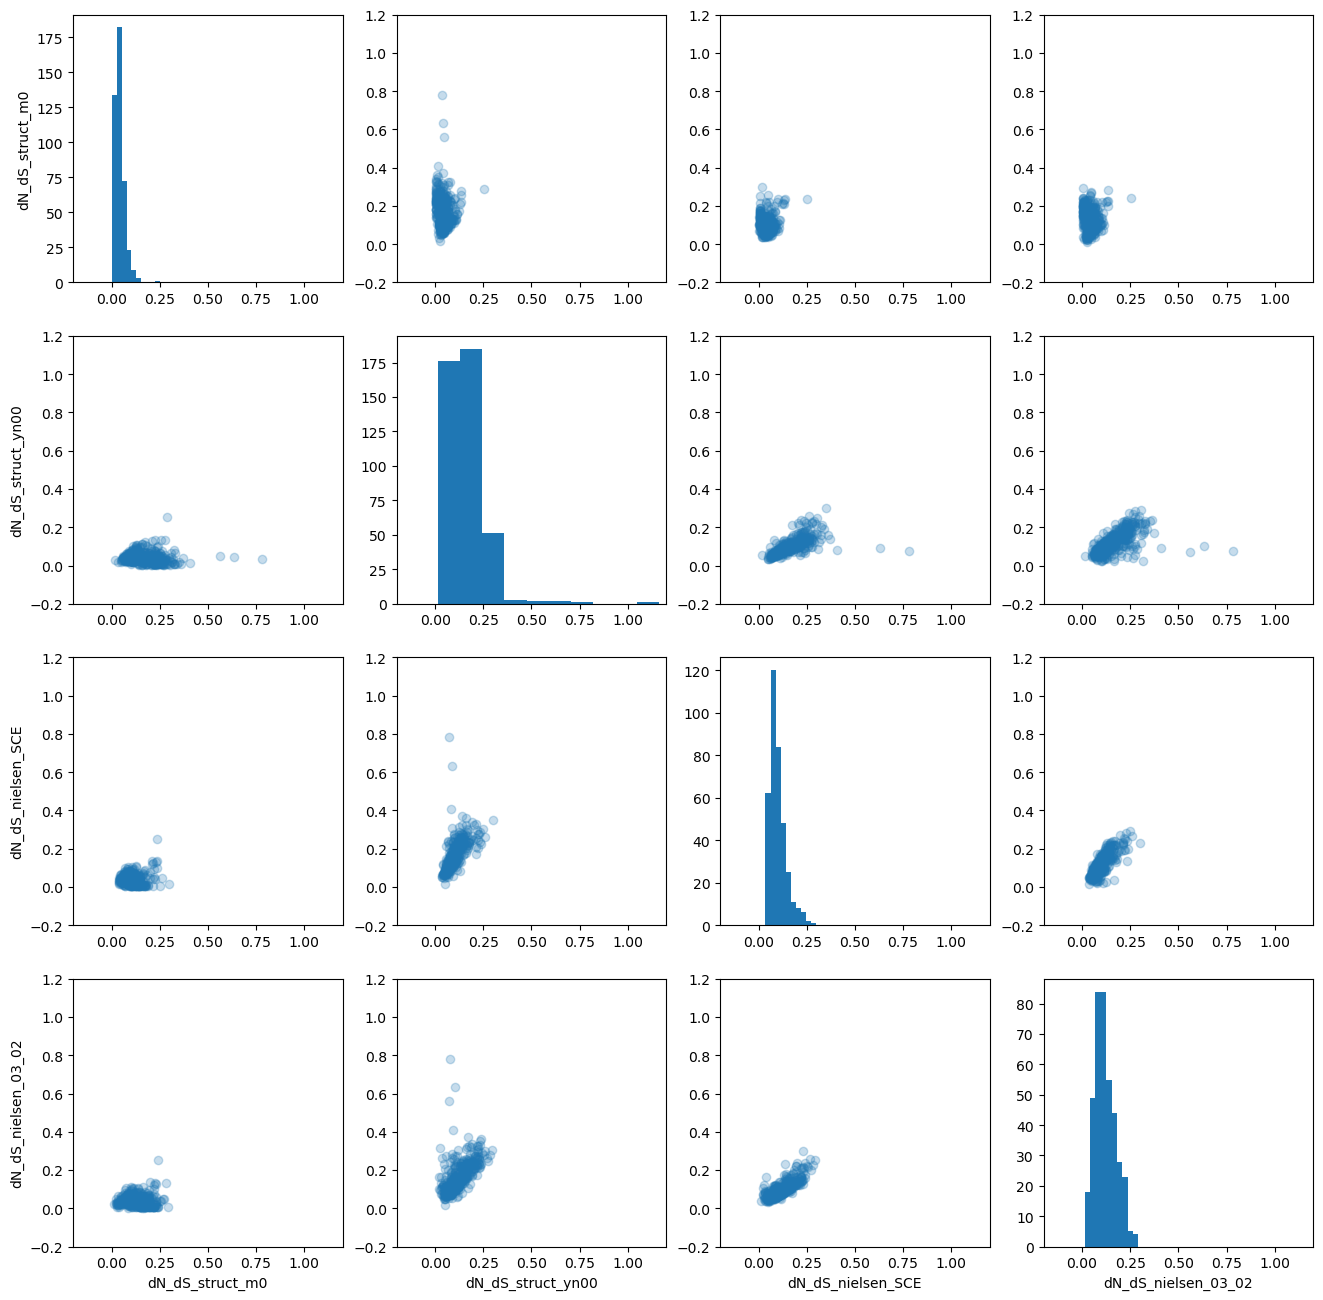

In [72]:
dnds_cols = [ 'dN_dS_struct_m0','dN_dS_struct_yn00','dN_dS_nielsen_SCE', 'dN_dS_nielsen_03_02']

fig, axarr = plt.subplots(len(dnds_cols),len(dnds_cols), figsize=(4*len(dnds_cols),4*(len(dnds_cols))))

xlim = (-0.2,1.2)

#good to quantify r2 here

for jj, dnds_col_jj in enumerate(dnds_cols):
    for kk, dnds_col_kk in enumerate(dnds_cols):
        ax = axarr[jj][kk]
        if jj == kk: 
            ax.hist(dnds_struct_data[dnds_col_jj])
            ax.set_xlim(xlim)
        else: 
            ax.scatter(dnds_struct_data[dnds_col_jj], dnds_struct_data[dnds_col_kk], alpha = 0.25)
            ax.set_xlim(xlim)
            ax.set_ylim(xlim)
        if kk==0: 
            ax.set_ylabel(dnds_col_jj)
        if jj == (len(dnds_cols)-1):
            ax.set_xlabel(dnds_col_kk)



our DNds and Nielsen Lab dnds are very correlated (apart from outliers with large values).  M0 is smaller and not well correlated with those. 

In [73]:
dnds_struct_data[dnds_struct_data['dN_dS_struct_yn00']>0.4]

,og_m0,tree_length_m0,kappa_m0,dN_dS_struct_m0,tree_length_dN_m0,tree_length_dS_m0,Mean(Conservation Rate) [ALL],CV(Type Conservation Rate) [ALL],Mean(Type Conservation Rate) [ALL],CV(Conservation Rate) [ALL],...,Std(log2(Abundances)) 10 Sp [EXP],1k_Mean_log2_Abundances [EXP],og_yn00,dN_dS_struct_yn00,dN_struct_yn00,dS_struct_yn00,dN_dS_nielsen_SCE,og_x,dN_dS_nielsen_03_02,og_y
og_ref,,,,,,,,,,,,,,,,,,,,,
OG1115_REF_Scer_AF-P06208-F1-model_v2,OG1115,123.617376,1.22458,0.04777,7.1403,149.4628,0.719437,0.073847,0.815603,0.103942,...,0.972957,9.341119,OG1115,0.56150,0.50180,0.91650,NaN,NaN,0.07050,OG1115
OG1230_REF_Scer_AF-P29465-F1-model_v2,OG1230,101.431756,1.23787,0.03595,4.8284,134.3010,0.675546,0.040949,0.804715,0.075825,...,0.772046,4.230896,OG1230,0.78170,1.83330,2.33980,0.0741,OG1230,0.07645,OG1230
OG1254_REF_Scer_AF-P40395-F1-model_v2,OG1254,266.608591,1.79811,0.01443,5.1339,355.7696,0.354468,0.168250,0.572760,0.290056,...,2.029057,NaN,OG1254,0.40765,0.77905,2.04350,0.0807,OG1254,0.09200,OG1254
OG1364_REF_Scer_AF-P27796-F1-model_v2,OG1364,81.567434,1.08378,0.04205,3.9993,95.1127,0.650851,0.056970,0.772934,0.083224,...,1.132560,NaN,OG1364,0.63280,0.54450,0.89970,0.0892,OG1364,0.10130,OG1364
OG1603_REF_Scer_AF-P25632-F1-model_v2,NaN,NaN,NaN,NaN,NaN,NaN,0.245098,0.000000,0.421569,0.000000,...,1.068788,8.788087,OG1603,0.66540,1.70570,2.56350,NaN,NaN,NaN,NaN
OG4312_REF_Scer_AF-P38280-F1-model_v2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,OG4312,1.16070,2.22240,1.91470,NaN,NaN,NaN,NaN
OG5722_alloascoidea_hylecoeti__OG5722__0_1167,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,OG5722,0.48000,0.90770,1.86915,NaN,NaN,NaN,NaN


Ouliers of YN00.  Includes RIC1 cluster from the RIC1/COX12 subcluster.  

## Many of the DN/DS values changed between YN00 and M0 - why? 

- Which OGs changed the most? 
- Of these, which are very abundant?

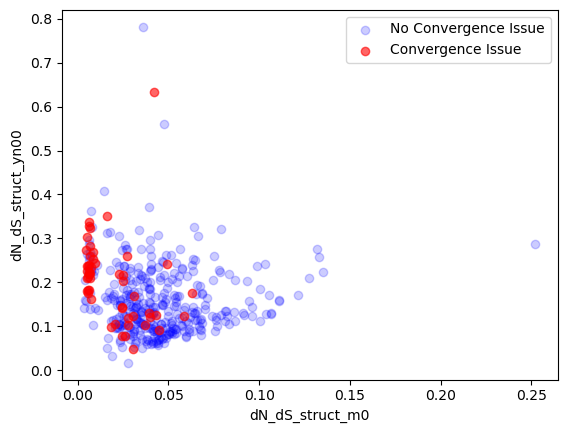

In [15]:
color_col = [ 'dN_dS_struct_m0','dN_dS_struct_yn00','dN_dS_nielsen_SCE', 'dN_dS_nielsen_03_02']

fig, ax = plt.subplots()

#xlim = (-0.2,1.2)

x_value = 'dN_dS_struct_m0'#'Median(log2(Abundances)) 10 Sp [EXP]'#'Mean(Conservation Rate) [ALL]' #'dN_dS_struct_yn00'#'dN_dS_struct_m0'
y_value = 'dN_dS_struct_yn00' #'dN_dS_struct_yn00' #'dN_dS_nielsen_SCE'#'dN_dS_struct_yn00'

dnds_foreground = (dnds_struct_data[dnds_struct_data['convergence_issue_m0']==True], 'r',0.6,'Convergence Issue')
dnds_background = (dnds_struct_data[dnds_struct_data['convergence_issue_m0']==False], 'b',0.2,'No Convergence Issue')


#good to quantify r2 here
for (data_to_plot, color, alpha, label) in [dnds_background, dnds_foreground]:
    ax.scatter(data_to_plot[x_value], data_to_plot[y_value], color = color, alpha = alpha, label=label)
# ax.set_xlim(xlim)
# ax.set_ylim(xlim)
ax.set_ylabel(y_value)
ax.set_xlabel(x_value)
ax.legend()


- What are the larger YN00 values that are close to 0 for the M0 calculations? 
These seem to have 'convergence issues'

- What are the yn00 outliers that are much smaller for M0
These seem to have bad sequences that cause excessive trimming in yn00

In [12]:
#dnds_struct_data[(dnds_struct_data['dN_dS_struct_m0']<0.03)&(dnds_struct_data['dN_dS_struct_yn00']>0.2)].sort_values(by = 'dN_dS_struct_yn00', ascending=False)

OG1230
YN00:  2604 sites
M0: 834 sites
    
    
OG1364
YN00: 12 sites
M0: 1137 sites
    
This could be why my DN/DS Values differ so much between YN00 and M0

In [76]:
col_to_view = ['dN_dS_struct_m0','dN_dS_struct_yn00','dN_dS_nielsen_SCE', 'dN_dS_nielsen_03_02']
dnds_struct_data.loc[['OG1273_REF_Scer_AF-P40012-F1-model_v2','OG3104_REF_Scer_AF-P53954-F1-model_v2'],col_to_view]

,dN_dS_struct_m0,dN_dS_struct_yn00,dN_dS_nielsen_SCE,dN_dS_nielsen_03_02
og_ref,,,,
OG1273_REF_Scer_AF-P40012-F1-model_v2,0.00614,0.32840,0.2126,0.2346
OG3104_REF_Scer_AF-P53954-F1-model_v2,0.00518,0.20875,0.1254,0.2071


That threshold was too high (I did m0 < 0.1 and YN00 > 0.3) - these ones were those with the highest YN00

I changed to m0<0.03 and YN00 > 0.2 and picked a few in the middle of that to understand this cloud which shrunk the most. 

OG1273_REF_Scer_AF-P40012-F1-model_v2
YN00


OG3104_REF_Scer_AF-P53954-F1-model_v2


Both of those have 'Check Convergence in the M0 calculation' 

1) Can YN00 use cleandata = 1? 

ran with 20230301_run_yn00_test_cleandata.sh (via call_code_singularity_bens_cpu.sh)

NO: I get this error

YN00 in paml version 4.10.6, November 2022

Reading options from /home/heineike_wsl2/alphafold/selection_calculations/m0_yn00_comparison/yn00/OG1364_REF_Scer_AF-P27796-F1-model_v2/yn00.ctl.

option cleandata in /home/heineike_wsl2/alphafold/selection_calculations/m0_yn00_comparison/yn00/OG1364_REF_Scer_AF-P27796-F1-model_v2/yn00.ctl


2) Calculate YN00 for OG1230 and OG1364 after deleting the two trouble sequences

In [69]:
#Ran 20230301_struct_align_dnds_msas_yn00_filter.py from call_code_singularity_bens_cpu.sh

alignment = 'OG1230_REF_Scer_AF-P29465-F1-model_v2'#'OG1364_REF_Scer_AF-P27796-F1-model_v2'
yn00_dir = base_dir + os.sep + os.path.normpath('selection_calculations/m0_yn00_comparison/yn00/' + alignment + '_filtered') + os.sep
output_file = yn00_dir + 'yn00.csv'
paml_gene_dn_ds_file = yn00_dir +  'yn00.out'
(dN_dS, dN, dS) = dyt.calMean_dN_dS_yn00(paml_gene_dn_ds_file, output_file, method="median dN_dS, dN, dS")
print((dN_dS, dN, dS))
#dN_dS_struct.append(dN_dS)
#dN_struct.append(dN)
#dS_struct.append(dS)

(0.0908, 0.2375, 2.6158)


3) Plot M0 for OG1230, OG1364, and also two that had a convergence warning (OG1273 and OG3104) when I remove the trouble sequences. 




In [ ]:
#Tried to run ETE3 in singularity, but I got an error with the python version: 
https://github.com/etetoolkit/ete/issues/500
sudo singularity build codeml.sif ~/github/diverse_yeast/codeml_singularity.cfg

UnsatisfiableError: The following specifications were found
to be incompatible with the existing python installation in your environment:

Specifications:

  - ete_toolchain -> python[version='>=2.7,<2.8.0a0|>=3.4,<3.5.0a0|>=3.5,<3.6.0a0|>=3.6,<3.7.0a0']

Your python: python=3.10

If python is on the left-most side of the chain, that's the version you've asked for.
When python appears to the right, that indicates that the thing on the left is somehow
not available for the python version you are constrained to. Note that conda will not
change your python version to a different minor version unless you explicitly specify
that.

The following specifications were found to be incompatible with your system:

  - feature:/linux-64::__glibc==2.31=0
  - feature:|@/linux-64::__glibc==2.31=0

Your installed version is: 2.31


In [22]:
alignment = 'OG1273_REF_Scer_AF-P40012-F1-model_v2'

tree_orig = base_dir + os.sep + os.path.normpath('msas/structural/tm_align/trees/' + alignment + '.tm.fasta.clipkit.treefile')
tree_renamed = tree_orig+'.renamed'

tree_filtered = tree_orig + '.filtered'
full_tree = Tree(tree_renamed, format=1) #Using flexible with internal node names as support is not in the right format to load with format = 0
full_tree.prune(list(aln_len_df_filt['seq_id']))
full_tree.write(format=5, outfile = tree_filtered)



In [11]:
seq_filt_thresh = 0.85
msa_cds_trimmed = base_dir + os.sep +  os.path.normpath('msas/structural/tm_align/cds_trim_strict/' + alignment +  '.tm.fasta.clipkit.cds')
msa_cds_trimmed_renamed = msa_cds_trimmed+'.renamed' 
msa_cds_trimmed_seqs = SeqIO.parse(msa_cds_trimmed_renamed, 'fasta')

seq_ids = []
aln_len_sq = [] 

for record in msa_cds_trimmed_seqs: 
    seq_ids.append(record.id)
    seq_squeezed = len([res for res in record.seq if res!='-'])
    aln_len_sq.append(seq_squeezed)
aln_len = len(record.seq)

aln_len_df = pd.DataFrame.from_dict({'seq_id': seq_ids,'seq_len_squeeze':aln_len_sq})
aln_len_df['seq_len_pct'] = aln_len_df['seq_len_squeeze']/aln_len

aln_len_df_filt = aln_len_df[aln_len_df['seq_len_pct']>seq_filt_thresh]


In [12]:
aln_len_df_filt

,seq_id,seq_len_squeeze,seq_len_pct
0,OG1273_0,1359,0.993421
1,OG1273_1,1368,1.000000
2,OG1273_2,1320,0.964912
3,OG1273_3,1323,0.967105
4,OG1273_4,1365,0.997807
5,OG1273_5,1350,0.986842
6,OG1273_6,1359,0.993421
7,OG1273_7,1362,0.995614
8,OG1273_8,1365,0.997807
9,OG1273_9,1368,1.000000


In [16]:
list(aln_len_df_filt['seq_id'])

['OG1273_0',
 'OG1273_1',
 'OG1273_2',
 'OG1273_3',
 'OG1273_4',
 'OG1273_5',
 'OG1273_6',
 'OG1273_7',
 'OG1273_8',
 'OG1273_9',
 'OG1273_10',
 'OG1273_11',
 'OG1273_12',
 'OG1273_13',
 'OG1273_14',
 'OG1273_15',
 'OG1273_16',
 'OG1273_17',
 'OG1273_18',
 'OG1273_19',
 'OG1273_20',
 'OG1273_21',
 'OG1273_22',
 'OG1273_24']

In [19]:
full_tree.write()

'(OG1273_0:0.2155,((((((((OG1273_1:0.47461,OG1273_11:0.92992)1:0.18165,OG1273_19:0.46494)1:0.1845,(OG1273_9:1.18155,((OG1273_12:0.33395,OG1273_13:0.31556)1:0.3092,OG1273_15:0.77596)1:0.1396)1:0.07844)1:0.13681,OG1273_20:1.16236)1:0.19948,OG1273_23:1.03685)1:0.32019,(OG1273_4:1.38141,((OG1273_7:0.7726,OG1273_21:0.81301)1:0.17383,OG1273_18:1.46625)1:0.13402)1:0.06383)1:0.08058,(((((OG1273_2:1.27297,OG1273_16:1.29017)1:0.89732,((OG1273_5:1.42549,OG1273_10:1.23312)1:0.75056,OG1273_24:1.62813)1:0.42354)1:0.16783,OG1273_22:2.20712)1:0.23916,OG1273_3:1.24811)1:0.21627,(OG1273_14:0.98736,OG1273_17:1.23495)1:0.30455)1:0.09799)1:0.46325,OG1273_8:0.58424)1:0.87764,OG1273_6:0.28767);'

In [23]:
full_tree.write(format=5)

'(OG1273_0:0.2155,((((((((OG1273_1:0.47461,OG1273_11:0.92992):0.18165,OG1273_19:0.46494):0.1845,(OG1273_9:1.18155,((OG1273_12:0.33395,OG1273_13:0.31556):0.3092,OG1273_15:0.77596):0.1396):0.07844):0.13681,OG1273_20:1.16236):0.19948,OG1273_23:1.03685):0.32019,(OG1273_4:1.38141,((OG1273_7:0.7726,OG1273_21:0.81301):0.17383,OG1273_18:1.46625):0.13402):0.06383):0.08058,(((((OG1273_2:1.27297,OG1273_16:1.29017):0.89732,((OG1273_5:1.42549,OG1273_10:1.23312):0.75056,OG1273_24:1.62813):0.42354):0.16783,OG1273_22:2.20712):0.23916,OG1273_3:1.24811):0.21627,(OG1273_14:0.98736,OG1273_17:1.23495):0.30455):0.09799):0.46325,OG1273_8:0.58424):0.87764,OG1273_6:0.28767);'


4) Calculate the trimming ratios for YN00 and M0, plot these
    A) Is the correspondence for M0 and YN00 better when there is not as much trimming in YN00? 

In [ ]:
for jj, dnds_col in enumerate(dnds_cols):
    for kk, param_to_plot in enumerate(params_to_plot):
        ax = axarr[jj][kk]
        ax.scatter(struct_data_to_plot_df[param_to_plot], struct_data_to_plot_df[dnds_col], alpha = 0.25)
        ax.set_ylabel(dnds_col)
        ax.set_xlabel(param_to_plot)

- What are the high abundance, high dnds(M0) orthogroups? 

They aren't the ETC Proteins



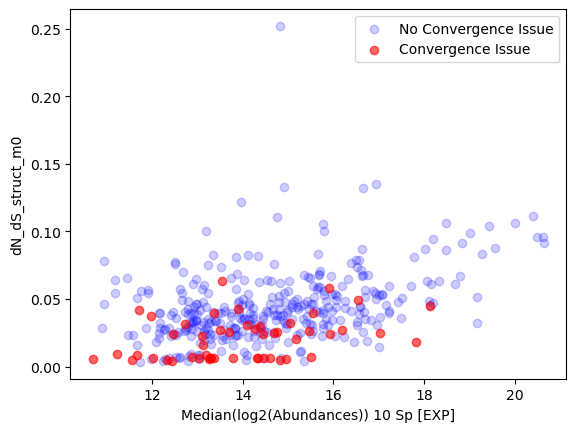

In [13]:
fig, ax = plt.subplots()

#xlim = (-0.2,1.2)

x_value =  'Median(log2(Abundances)) 10 Sp [EXP]'#'Mean(Conservation Rate) [ALL]' #'dN_dS_struct_yn00'#'dN_dS_struct_m0'
y_value = 'dN_dS_struct_m0'#'dN_dS_struct_yn00' #'dN_dS_nielsen_SCE'#'dN_dS_struct_yn00'

dnds_foreground = (dnds_struct_data[dnds_struct_data['convergence_issue_m0']==True], 'r',0.6,'Convergence Issue')
dnds_background = (dnds_struct_data[dnds_struct_data['convergence_issue_m0']==False], 'b',0.2,'No Convergence Issue')


#good to quantify r2 here
for (data_to_plot, color, alpha, label) in [dnds_background, dnds_foreground]:
    ax.scatter(data_to_plot[x_value], data_to_plot[y_value], color = color, alpha = alpha, label=label)
# ax.set_xlim(xlim)
# ax.set_ylim(xlim)
ax.set_ylabel(y_value)
ax.set_xlabel(x_value)
ax.legend()

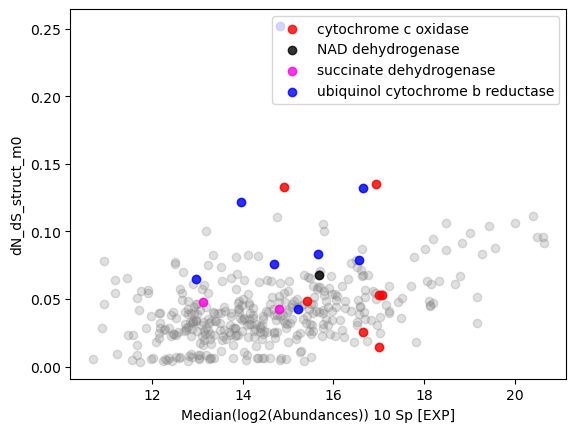

In [22]:
fig, ax = plt.subplots(1,1)

enzymes = {'cytochrome c oxidase': 'r',
           'NAD dehydrogenase': 'k',
           'succinate dehydrogenase': '#fc03e3', 
           'ubiquinol cytochrome b reductase': 'b'
          }

x_value =  'Median(log2(Abundances)) 10 Sp [EXP]'#'Mean(Conservation Rate) [ALL]' #'dN_dS_struct_yn00'#'dN_dS_struct_m0'
y_value = 'dN_dS_struct_m0'#'dN_dS_struct_yn00' #'dN_dS_nielsen_SCE'#'dN_dS_struct_yn00'

ax.scatter(dnds_struct_data[x_value], dnds_struct_data[y_value], alpha = 0.25, c= 'grey')

legend_handles = []
legend_labels = []
for enzyme, color in enzymes.items(): 
    dnds_struct_data_subset = dnds_struct_data[dnds_struct_data.index.isin(etc_proteins_clustered[etc_proteins_clustered['enzyme']==enzyme]['og_ref'])]
    handle = ax.scatter(dnds_struct_data_subset[x_value], dnds_struct_data_subset[y_value],color=color ,alpha = 0.8)
    legend_handles.append(handle)
    legend_labels.append(enzyme)
    
ax.set_xlabel(x_value)
ax.set_ylabel(y_value)
ax.legend(legend_handles, legend_labels)

In [27]:
cols_to_view = ['dN_dS_struct_m0','Median(log2(Abundances)) 10 Sp [EXP]', 'dN_dS_struct_yn00']
dnds_struct_data[(dnds_struct_data['dN_dS_struct_m0']>0.075)&(dnds_struct_data['Median(log2(Abundances)) 10 Sp [EXP]']>17)].sort_values(by='dN_dS_struct_m0', ascending=False).loc[:,cols_to_view]

,dN_dS_struct_m0,Median(log2(Abundances)) 10 Sp [EXP],dN_dS_struct_yn00
og_ref,,,
OG1145_REF_Scer_AF-P00358-F1-model_v2,0.11116,20.400527,0.16000
OG1193_REF_Scer_AF-P00924-F1-model_v2,0.10633,20.009531,0.12785
OG1208_REF_Scer_AF-P04806-F1-model_v2,0.10633,18.490435,0.13105
OG1813_REF_Scer_AF-P05694-F1-model_v2,0.10394,19.429356,0.12870
OG1631_REF_Scer_AF-P22217-F1-model_v2,0.09900,19.017555,0.23670
OG1432_REF_Scer_AF-P14540-F1-model_v2,0.09617,20.489390,0.12420
OG1424_REF_Scer_AF-P00560-F1-model_v2,0.09583,20.637585,0.14455
OG1112_REF_Scer_AF-P23254-F1-model_v2,0.09457,18.206976,0.15710
OG2794_REF_Scer_AF-P00950-F1-model_v2,0.09144,20.648300,0.12540


In [ ]:
OG1145 TDH3 - paralogs
OG1193 ENO1/ERR3/ERR2/ENO2/ERR1 - Paralogs
OG1208 HXK1/2 - paralogs
OG1813 Met6 (a paralog in species 43)
OG1631: TRX1/TRX2 - paralogs
OG1432: FBA1 -(paralogs but not in SC)
OG1424: PGK1 (paralog in species 43, species 49)
OG1112: TKL1/TKL2 - paralogs
OG2794: GPM1 - paralogs in species 0, 6
OG1892: GDH1/GDH3
OG1060: THI3/PDC1/PDC5/PDC6/MRK1 - paralogs
OG3063: YNK1 - NO paralogs
OG1835: MDH1 - paralogs in speies 6
OG1299: PYK1/PYK2 - paralogs
OG1016: ADH1/ADH2/ADH3/ADH5 - Paralogs

In [ ]:
# DN/DS vs Conservation Rate

In [213]:
#struct_data_to_plot_df[(struct_data_to_plot_df['Mean(Conservation rate AA)']<0.5)&(struct_data_to_plot_df['dN_dS_SCE']<0.15)]

In [214]:
#struct_data_to_plot_df[(struct_data_to_plot_df['Mean(Conservation rate AA)']<0.5)&(struct_data_to_plot_df['dN_dS_SCE']>0.20)]

In [218]:
# #Pick OGs that have higher dN/dS
# #4150, 2603, 
# #and lower: 
# #3677, 2845 
selected_og_refs = ['OG4150_REF_Scer_AF-P07256-F1-model_v2', 'OG2603_REF_Scer_AF-P50076-F1-model_v2', 'OG2845_REF_Scer_AF-P43577-F1-model_v2', 'OG3677_REF_Scer_AF-P47125-F1-model_v2', 'OG1299_REF_Scer_AF-P00549-F1-model_v2']
selected_ogs = [og_ref.split('_')[0] for og_ref in selected_og_refs]
struct_data_to_plot_df[struct_data_to_plot_df['og'].isin(selected_ogs)]

,og,og_ref,Mean(Mapping rate),Mean(Conservation rate AA),Mean(Conservation rate Type),OG_SCE,dN_dS_SCE,OG_nl_02_03,dN_dS_nl_02_03
13,OG1299,OG1299_REF_Scer_AF-P00549-F1-model_v2,0.974529,0.735859,0.828039,OG1299.out_yn00,0.0796,OG1299.out_yn00,0.1723
64,OG4150,OG4150_REF_Scer_AF-P07256-F1-model_v2,0.855788,0.494113,0.646492,OG4150.out_yn00,0.2287,OG4150.out_yn00,0.2826
374,OG2845,OG2845_REF_Scer_AF-P43577-F1-model_v2,0.897537,0.488116,0.615662,OG2845.out_yn00,0.1453,OG2845.out_yn00,0.1342
388,OG3677,OG3677_REF_Scer_AF-P47125-F1-model_v2,0.821292,0.494179,0.641265,OG3677.out_yn00,0.0904,OG3677.out_yn00,0.1178
405,OG2603,OG2603_REF_Scer_AF-P50076-F1-model_v2,0.806508,0.467627,0.656083,OG2603.out_yn00,0.2158,OG2603.out_yn00,0.2577
413,OG1299,OG1299_REF_Scer_AF-P52489-F1-model_v2,0.971635,0.637307,0.763982,OG1299.out_yn00,0.0796,OG1299.out_yn00,0.1723


In [13]:
struct_data_dnds

,og_x,og_ref,Mean(Mapping rate),Mean(Conservation rate AA),Mean(Conservation rate Type),OG_SCE,dN_dS_SCE,OG_nl_02_03,dN_dS_nl_02_03,dN_dS_struct,dN_struct,dS_struct,og_y
0,OG4352,OG4352_REF_Scer_AF-P00127-F1-model_v2,0.515006,0.488312,0.583829,OG4352.out_yn00,0.0924,OG4352.out_yn00,0.11860,0.1301,0.30970,2.7347,OG4352
1,OG3208,OG3208_REF_Scer_AF-P00128-F1-model_v2,0.983085,0.577829,0.742639,OG3208.out_yn00,0.1655,OG3208.out_yn00,0.14910,0.2197,0.40350,1.8272,OG3208
2,OG1016,OG1016_REF_Scer_AF-P00330-F1-model_v2,0.954863,0.736954,0.817145,NaN,NaN,NaN,NaN,0.1130,0.19800,1.7722,OG1016
3,OG1016,OG1016_REF_Scer_AF-P00331-F1-model_v2,0.938285,0.737345,0.817970,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,OG1145,OG1145_REF_Scer_AF-P00358-F1-model_v2,0.994326,0.769694,0.856194,NaN,NaN,OG1145.out_yn00,0.09955,0.1600,0.18535,1.2456,OG1145
...,...,...,...,...,...,...,...,...,...,...,...,...,...
545,NaN,OG6290_eremothecium_gossypii__OG6290__40_1372,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,OG6290
546,NaN,OG6574_eremothecium_gossypii__OG6574__40_137,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.2330,0.45360,1.9462,OG6574
547,NaN,OG6598_kazachstania_naganishii__OG6598__49_1006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,OG6598
548,NaN,OG7278_kazachstania_naganishii__OG7278__49_2415,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.3026,0.67650,2.0996,OG7278


NameError: name 'selected_og_refs' is not defined

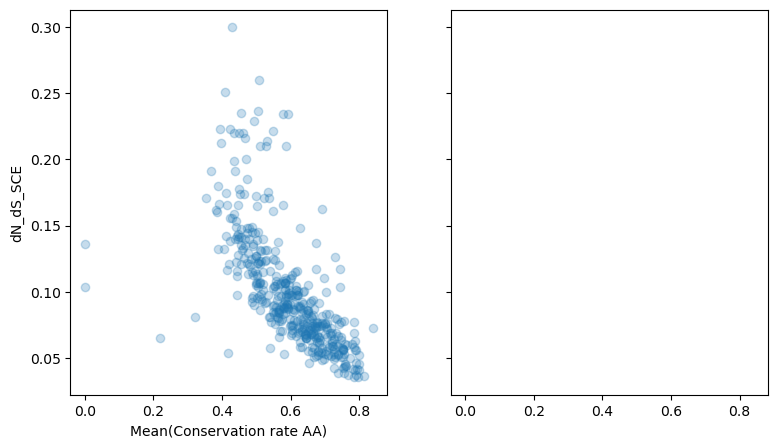

In [36]:
#Plot dN/dS for structural vs Neilsen

struct_data_dnds = pd.read_csv(base_dir + os.sep + os.path.normpath('selection_calculations/yn00/yn00_struct_neilsen.csv'))

fig, axarr = plt.subplots(1,2, figsize=(9,5), sharex=True, sharey = True)
dnds_seq_cols = [ 'dN_dS_SCE', 'dN_dS_struct']

for jj, dnds_seq_col in enumerate(dnds_seq_cols):   
    ax = axarr[jj]
    ax.scatter(struct_data_dnds['Mean(Conservation rate AA)'], struct_data_dnds[dnds_seq_col], alpha = 0.25)
    ax.set_ylabel(dnds_seq_col)
    ax.set_xlabel('Mean(Conservation rate AA)')
    
    struct_data_dnds_subset = struct_data_dnds[struct_data_dnds['og_ref'].isin(selected_og_refs)]
    
    ax.scatter(struct_data_dnds_subset['Mean(Conservation rate AA)'], struct_data_dnds_subset[dnds_seq_col],color='r' ,alpha = 0.8)
    ax.set_ylabel(dnds_seq_col)
    ax.set_xlabel('Mean(Conservation rate AA)')
    

Analysis of outlier groups: 

In [18]:
struct_data_dnds[struct_data_dnds['dN_dS_struct']>0.35]

,Unnamed: 0,og_x,og_ref,Mean(Mapping rate),Mean(Conservation rate AA),Mean(Conservation rate Type),OG_SCE,dN_dS_SCE,OG_nl_02_03,dN_dS_nl_02_03,dN_dS_struct,dN_struct,dS_struct,og_y
51,51,OG1115,OG1115_REF_Scer_AF-P06208-F1-model_v2,0.816146,0.699453,0.792947,NaN,NaN,OG1115.out_yn00,0.07050,0.56150,0.50180,0.91650,OG1115
175,175,OG1640,OG1640_REF_Scer_AF-P23501-F1-model_v2,0.777894,0.438573,0.628229,OG1640.out_yn00,0.1396,OG1640.out_yn00,0.17035,0.37080,0.71020,1.89560,OG1640
188,188,OG1603,OG1603_REF_Scer_AF-P25632-F1-model_v2,0.483782,0.219630,0.341672,OG1603.out_yn00,0.0652,OG1603.out_yn00,0.09690,0.66540,1.70570,2.56350,OG1603
195,195,OG1364,OG1364_REF_Scer_AF-P27796-F1-model_v2,0.875985,0.627606,0.745329,OG1364.out_yn00,0.0892,OG1364.out_yn00,0.10130,0.63280,0.54450,0.89970,OG1364
203,203,OG1230,OG1230_REF_Scer_AF-P29465-F1-model_v2,0.656116,0.647399,0.771185,OG1230.out_yn00,0.0741,OG1230.out_yn00,0.07645,0.78170,1.83330,2.33980,OG1230
289,289,OG3242,OG3242_REF_Scer_AF-P38179-F1-model_v2,0.810937,0.434906,0.639977,OG3242.out_yn00,0.1586,OG3242.out_yn00,0.23930,0.36230,0.75585,1.96445,OG3242
293,293,OG4312,OG4312_REF_Scer_AF-P38280-F1-model_v2,1.000000,0.000000,0.000000,OG4312.out_yn00,0.1359,OG4312.out_yn00,0.16775,1.16070,2.22240,1.91470,OG4312
347,347,OG1254,OG1254_REF_Scer_AF-P40395-F1-model_v2,0.606233,0.322243,0.520691,OG1254.out_yn00,0.0807,OG1254.out_yn00,0.09200,0.40765,0.77905,2.04350,OG1254
542,542,NaN,OG5722_alloascoidea_hylecoeti__OG5722__0_1167,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.48000,0.90770,1.86915,OG5722


In [ ]:
Has paralogs: 
    OG1115 (had dS > 50 )
    OG1603 (its paralog OG1603_REF_Scer_AF-P16120-F1-model_v2 failed dS filter)  #Check to see if I included the C0 clusters .  This one has a Pombe and a Sc cluster
    OG1640


No paralogs 
OG1364 (had dS > 50)
OG1230 
OG3242 (fairly high in both) 

In [16]:
struct_data_dnds[struct_data_dnds['og_x'].isin(struct_data_dnds[struct_data_dnds['dN_dS_struct']>0.35]['og_x'])]

,Unnamed: 0,og_x,og_ref,Mean(Mapping rate),Mean(Conservation rate AA),Mean(Conservation rate Type),OG_SCE,dN_dS_SCE,OG_nl_02_03,dN_dS_nl_02_03,dN_dS_struct,dN_struct,dS_struct,og_y
51,51,OG1115,OG1115_REF_Scer_AF-P06208-F1-model_v2,0.816146,0.699453,0.792947,NaN,NaN,OG1115.out_yn00,0.07050,0.56150,0.50180,0.91650,OG1115
136,136,OG1603,OG1603_REF_Scer_AF-P16120-F1-model_v2,0.953019,0.673427,0.777066,OG1603.out_yn00,0.0652,OG1603.out_yn00,0.09690,NaN,NaN,NaN,OG1603
175,175,OG1640,OG1640_REF_Scer_AF-P23501-F1-model_v2,0.777894,0.438573,0.628229,OG1640.out_yn00,0.1396,OG1640.out_yn00,0.17035,0.37080,0.71020,1.89560,OG1640
188,188,OG1603,OG1603_REF_Scer_AF-P25632-F1-model_v2,0.483782,0.219630,0.341672,OG1603.out_yn00,0.0652,OG1603.out_yn00,0.09690,0.66540,1.70570,2.56350,OG1603
195,195,OG1364,OG1364_REF_Scer_AF-P27796-F1-model_v2,0.875985,0.627606,0.745329,OG1364.out_yn00,0.0892,OG1364.out_yn00,0.10130,0.63280,0.54450,0.89970,OG1364
203,203,OG1230,OG1230_REF_Scer_AF-P29465-F1-model_v2,0.656116,0.647399,0.771185,OG1230.out_yn00,0.0741,OG1230.out_yn00,0.07645,0.78170,1.83330,2.33980,OG1230
284,284,OG4312,OG4312_REF_Scer_AF-P38115-F1-model_v2,0.845155,0.490588,0.637199,OG4312.out_yn00,0.1359,OG4312.out_yn00,0.16775,0.25230,0.64240,2.69140,OG4312
289,289,OG3242,OG3242_REF_Scer_AF-P38179-F1-model_v2,0.810937,0.434906,0.639977,OG3242.out_yn00,0.1586,OG3242.out_yn00,0.23930,0.36230,0.75585,1.96445,OG3242
293,293,OG4312,OG4312_REF_Scer_AF-P38280-F1-model_v2,1.000000,0.000000,0.000000,OG4312.out_yn00,0.1359,OG4312.out_yn00,0.16775,1.16070,2.22240,1.91470,OG4312
347,347,OG1254,OG1254_REF_Scer_AF-P40395-F1-model_v2,0.606233,0.322243,0.520691,OG1254.out_yn00,0.0807,OG1254.out_yn00,0.09200,0.40765,0.77905,2.04350,OG1254


In [3]:
selected_og_refs = ['OG4150_REF_Scer_AF-P07256-F1-model_v2', 'OG2603_REF_Scer_AF-P50076-F1-model_v2', 'OG2845_REF_Scer_AF-P43577-F1-model_v2', 'OG3677_REF_Scer_AF-P47125-F1-model_v2', 'OG1299_REF_Scer_AF-P00549-F1-model_v2']
selected_ogs = [og_ref.split('_')[0] for og_ref in selected_og_refs]
struct_data_dnds[struct_data_dnds['og_x'].isin(selected_ogs)]

,Unnamed: 0,Unnamed: 0.1,og_x,og_ref,Mean(Mapping rate),Mean(Conservation rate AA),Mean(Conservation rate Type),OG_SCE,dN_dS_SCE,OG_nl_02_03,...,dN_dS_struct,dN_struct,dS_struct,og_y,og,tree_length,kappa,dN_dS_struct_m0,tree_length_dS,tree_length_dS.1
13,13,13,OG1299,OG1299_REF_Scer_AF-P00549-F1-model_v2,0.974529,0.735859,0.828039,OG1299.out_yn00,0.0796,OG1299.out_yn00,...,0.1063,0.15790,1.49275,OG1299,OG1299,35.541141,1.33863,0.08320,3.1528,37.8925
64,64,64,OG4150,OG4150_REF_Scer_AF-P07256-F1-model_v2,0.855788,0.494113,0.646492,OG4150.out_yn00,0.2287,OG4150.out_yn00,...,0.2764,0.54320,1.81100,OG4150,OG4150,40.471574,1.15876,0.13195,5.0681,38.4103
374,374,374,OG2845,OG2845_REF_Scer_AF-P43577-F1-model_v2,0.897537,0.488116,0.615662,OG2845.out_yn00,0.1453,OG2845.out_yn00,...,0.1672,0.34990,2.31910,OG2845,OG2845,96.299127,1.33293,0.04244,5.0509,119.0216
388,388,388,OG3677,OG3677_REF_Scer_AF-P47125-F1-model_v2,0.821292,0.494179,0.641265,OG3677.out_yn00,0.0904,OG3677.out_yn00,...,0.1337,0.36390,2.56720,OG3677,OG3677,68.645225,1.30534,0.04969,4.0479,81.4599
405,405,405,OG2603,OG2603_REF_Scer_AF-P50076-F1-model_v2,0.806508,0.467627,0.656083,OG2603.out_yn00,0.2158,OG2603.out_yn00,...,0.2975,0.65965,2.11475,OG2603,OG2603,152.847089,1.53130,0.03992,6.9458,173.9918
413,413,413,OG1299,OG1299_REF_Scer_AF-P52489-F1-model_v2,0.971635,0.637307,0.763982,OG1299.out_yn00,0.0796,OG1299.out_yn00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


M0 Selection calculations for each orthogroup

NameError: name 'selected_og_refs' is not defined

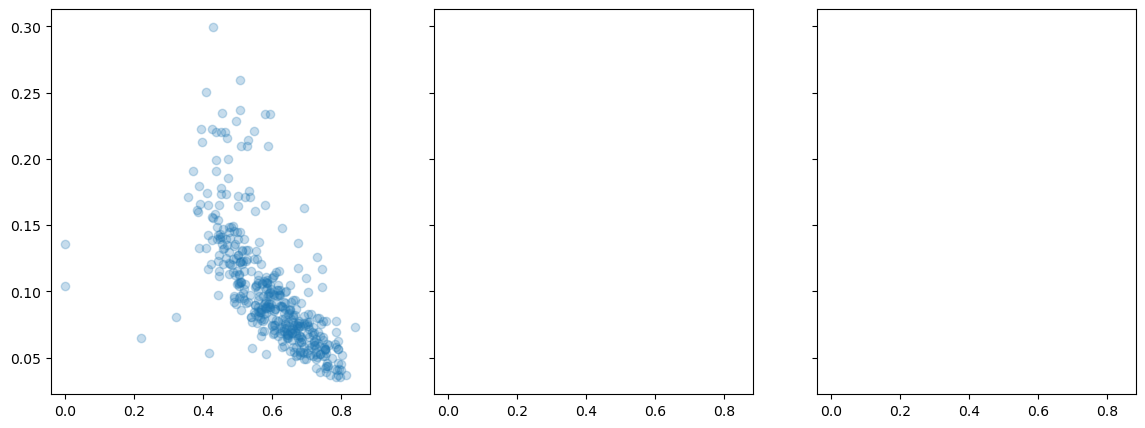

In [36]:
#Plot dN/dS for structural vs Neilsen

struct_data_dnds = pd.read_csv(base_dir + os.sep + os.path.normpath('selection_calculations/m0/m0_struct_neilsen_yn00.csv'))

fig, axarr = plt.subplots(1,3, figsize=(14,5), sharex=True, sharey = True)
dnds_seq_cols = [ 'dN_dS_SCE', 'dN_dS_struct', 'dN_dS_struct_m0']

for jj, dnds_seq_col in enumerate(dnds_seq_cols):   
    ax = axarr[jj]
    ax.scatter(struct_data_dnds['Mean(Conservation rate AA)'], struct_data_dnds[dnds_seq_col], alpha = 0.25)
   
    struct_data_dnds_subset = struct_data_dnds[struct_data_dnds['og_ref'].isin(selected_og_refs)]
    
    ax.scatter(struct_data_dnds_subset['Mean(Conservation rate AA)'], struct_data_dnds_subset[dnds_seq_col],color='r' ,alpha = 0.8)
    ax.set_ylabel(dnds_seq_col)
    ax.set_xlabel('Mean(Conservation rate AA)')

Text(0.5, 0, 'Mean(Conservation rate AA)')

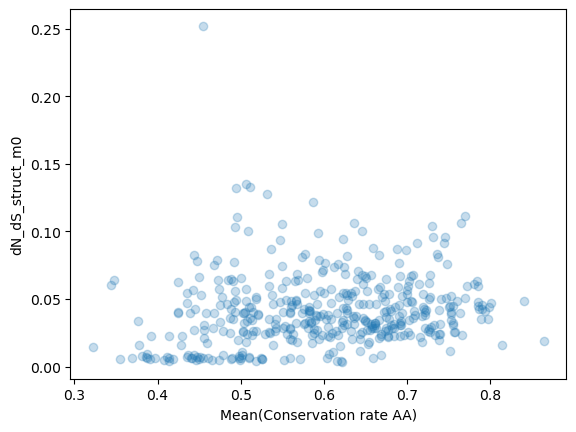

In [37]:
fig, ax = plt.subplots(1,1)

ax.scatter(struct_data_dnds['Mean(Conservation rate AA)'], struct_data_dnds['dN_dS_struct_m0'], alpha = 0.25)

#struct_data_dnds_subset = struct_data_dnds[struct_data_dnds['og_ref'].isin(selected_og_refs)]
#ax.scatter(struct_data_dnds_subset['Mean(Conservation rate AA)'], struct_data_dnds_subset['dN_dS_struct_m0'],color='r' ,alpha = 0.8)
ax.set_ylabel('dN_dS_struct_m0')
ax.set_xlabel('Mean(Conservation rate AA)')

In [ ]:
## Many of these values changed between YN00 and M0 - why

Text(0.5, 0, 'Mean(Conservation rate AA)')

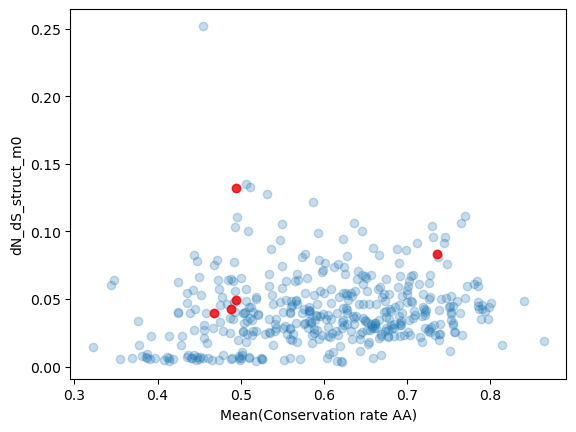

In [223]:
fig, ax = plt.subplots(1,1)

ax.scatter(struct_data_dnds['Mean(Conservation rate AA)'], struct_data_dnds['dN_dS_struct_m0'], alpha = 0.25)

struct_data_dnds_subset = struct_data_dnds[struct_data_dnds['og_ref'].isin(selected_og_refs)]

ax.scatter(struct_data_dnds_subset['Mean(Conservation rate AA)'], struct_data_dnds_subset['dN_dS_struct_m0'],color='r' ,alpha = 0.8)
ax.set_ylabel('dN_dS_struct_m0')
ax.set_xlabel('Mean(Conservation rate AA)')

In [41]:
struct_data_dnds.sort_values(by='dN_dS_struct_m0')

,Unnamed: 0,Unnamed: 0.1,og_x,og_ref,Mean(Mapping rate),Mean(Conservation rate AA),Mean(Conservation rate Type),OG_SCE,dN_dS_SCE,OG_nl_02_03,...,dN_dS_struct,dN_struct,dS_struct,og_y,og,tree_length,kappa,dN_dS_struct_m0,tree_length_dS,tree_length_dS.1
266,266,266,OG3008,OG3008_REF_Scer_AF-P36076-F1-model_v2,0.391014,0.621655,0.765640,OG3008.out_yn00,0.0688,OG3008.out_yn00,...,0.14165,0.30875,2.18665,OG3008,OG3008,702.694735,1.36836,0.00354,3.3044,933.2096
378,378,378,OG2999,OG2999_REF_Scer_AF-P43636-F1-model_v2,0.795070,0.518443,0.663924,OG2999.out_yn00,0.1017,OG2999.out_yn00,...,0.20500,0.49610,2.46400,OG2999,OG2999,1037.138851,1.53711,0.00391,5.4388,1392.2430
517,517,517,OG1764,OG1764_REF_Scer_AF-Q12189-F1-model_v2,0.916595,0.620356,0.736102,OG1764.out_yn00,0.0978,OG1764.out_yn00,...,0.15965,0.34705,2.11815,OG1764,OG1764,848.177639,1.40233,0.00416,4.4265,1064.9058
354,354,354,OG1933,OG1933_REF_Scer_AF-P40545-F1-model_v2,0.920130,0.615480,0.724607,OG1933.out_yn00,0.1045,OG1933.out_yn00,...,0.15670,0.35105,2.45255,OG1933,OG1933,697.590301,1.33537,0.00434,4.1879,965.1963
304,304,304,OG3018,OG3018_REF_Scer_AF-P38635-F1-model_v2,0.877038,0.413258,0.588927,OG3018.out_yn00,0.1424,OG3018.out_yn00,...,0.27300,0.62865,2.30075,OG3018,OG3018,1064.056007,1.58679,0.00435,6.3933,1470.2429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545,545,545,NaN,OG6290_eremothecium_gossypii__OG6290__40_1372,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,OG6290,NaN,NaN,NaN,NaN,NaN,NaN
546,546,546,NaN,OG6574_eremothecium_gossypii__OG6574__40_137,NaN,NaN,NaN,NaN,NaN,NaN,...,0.23300,0.45360,1.94620,OG6574,NaN,NaN,NaN,NaN,NaN,NaN
547,547,547,NaN,OG6598_kazachstania_naganishii__OG6598__49_1006,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,OG6598,NaN,NaN,NaN,NaN,NaN,NaN
548,548,548,NaN,OG7278_kazachstania_naganishii__OG7278__49_2415,NaN,NaN,NaN,NaN,NaN,NaN,...,0.30260,0.67650,2.09960,OG7278,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
struct_data_dnds[(struct_data_dnds['dN_dS_struct_m0']>0.09)&(struct_data_dnds['Mean(Conservation rate AA)']<0.6)].sort_values(by='dN_dS_struct_m0', ascending=False).loc[:,['og_ref','og','dN_dS_struct_m0', 'Mean(Conservation rate AA)']]

,og_ref,og,dN_dS_struct_m0,Mean(Conservation rate AA)
276,OG4552_REF_Scer_AF-P37299-F1-model_v2,OG4552,0.25202,0.455022
247,OG4555_REF_Scer_AF-P32799-F1-model_v2,OG4555,0.13541,0.506526
7,OG4316_REF_Scer_AF-P00424-F1-model_v2,OG4316,0.13305,0.510637
64,OG4150_REF_Scer_AF-P07256-F1-model_v2,OG4150,0.13195,0.494113
105,OG4346_REF_Scer_AF-P10174-F1-model_v2,OG4346,0.12753,0.531120
88,OG4360_REF_Scer_AF-P08525-F1-model_v2,OG4360,0.12166,0.587126
16,OG5441_REF_Scer_AF-P00724-F1-model_v2,OG5441,0.11105,0.495190
419,OG1377_REF_Scer_AF-P53090-F1-model_v2,OG1377,0.10546,0.550098
257,OG2112_REF_Scer_AF-P33421-F1-model_v2,OG2112,0.10336,0.492917
122,OG1122_REF_Scer_AF-P13711-F1-model_v2,OG1122,0.10054,0.508399


In [62]:
list(set(list(etc_proteins_clustered['enzyme'])))

['cytochrome c oxidase',
 'NAD dehydrogenase',
 'succinate dehydrogenase',
 'ubiquinol cytochrome b reductase']

In [67]:
struct_data_dnds[struct_data_dnds['og_ref'].isin(etc_proteins_clustered[etc_proteins_clustered['enzyme']==enzyme]['og_ref'])]

,Unnamed: 0,Unnamed: 0.1,og_x,og_ref,Mean(Mapping rate),Mean(Conservation rate AA),Mean(Conservation rate Type),OG_SCE,dN_dS_SCE,OG_nl_02_03,...,dN_dS_struct,dN_struct,dS_struct,og_y,og,tree_length,kappa,dN_dS_struct_m0,tree_length_dS,tree_length_dS.1
0,0,0,OG4352,OG4352_REF_Scer_AF-P00127-F1-model_v2,0.515006,0.488312,0.583829,OG4352.out_yn00,0.0924,OG4352.out_yn00,...,0.13010,0.3097,2.73470,OG4352,OG4352,33.684114,1.43708,0.06460,2.6508,41.0328
1,1,1,OG3208,OG3208_REF_Scer_AF-P00128-F1-model_v2,0.983085,0.577829,0.742639,OG3208.out_yn00,0.1655,OG3208.out_yn00,...,0.21970,0.4035,1.82720,OG3208,OG3208,54.335382,1.26238,0.08318,4.8548,58.3681
56,56,56,OG2248,OG2248_REF_Scer_AF-P07143-F1-model_v2,0.805705,0.790176,0.862447,OG2248.out_yn00,0.0462,OG2248.out_yn00,...,0.06630,0.1073,1.76920,OG2248,OG2248,36.063606,1.26135,0.04297,1.7977,41.8418
64,64,64,OG4150,OG4150_REF_Scer_AF-P07256-F1-model_v2,0.855788,0.494113,0.646492,OG4150.out_yn00,0.2287,OG4150.out_yn00,...,0.27640,0.5432,1.81100,OG4150,OG4150,40.471574,1.15876,0.13195,5.0681,38.4103
65,65,65,OG2006,OG2006_REF_Scer_AF-P07257-F1-model_v2,0.859501,0.471097,0.626659,OG2006.out_yn00,0.1999,OG2006.out_yn00,...,0.32255,0.6303,1.94075,OG2006,OG2006,85.816195,1.26877,0.07908,6.9683,88.1218
81,81,81,OG3575,OG3575_REF_Scer_AF-P08067-F1-model_v2,0.796899,0.748114,0.826812,OG3575.out_yn00,0.0658,OG3575.out_yn00,...,0.08840,0.1484,1.61560,OG3575,OG3575,24.577237,1.33301,0.07590,2.0340,26.7988
88,88,88,OG4360,OG4360_REF_Scer_AF-P08525-F1-model_v2,0.864742,0.587126,0.725837,OG4360.out_yn00,0.2101,OG4360.out_yn00,...,0.17170,0.3492,2.08780,OG4360,OG4360,28.447028,1.56897,0.12166,3.4444,28.3119
171,171,171,OG4744,OG4744_REF_Scer_AF-P22289-F1-model_v2,0.800866,0.547609,0.698766,OG4744.out_yn00,0.2211,OG4744.out_yn00,...,0.20385,0.3558,1.80320,OG4744,OG4744,81.672935,1.63435,0.09353,8.1023,86.6281
276,276,276,OG4552,OG4552_REF_Scer_AF-P37299-F1-model_v2,0.440031,0.455022,0.598244,OG4552.out_yn00,0.2350,OG4552.out_yn00,...,0.28830,0.5350,1.95820,OG4552,OG4552,24.663009,1.46351,0.25202,4.7162,18.7136


In [66]:
etc_proteins_clustered[etc_proteins_clustered['enzyme']==enzyme]['og_ref']

6     OG2006_REF_Scer_AF-P07257-F1-model_v2
9     OG2248_REF_Scer_AF-P07143-F1-model_v2
12    OG3208_REF_Scer_AF-P00128-F1-model_v2
14    OG3575_REF_Scer_AF-P08067-F1-model_v2
16    OG4150_REF_Scer_AF-P07256-F1-model_v2
20    OG4352_REF_Scer_AF-P00127-F1-model_v2
21    OG4360_REF_Scer_AF-P08525-F1-model_v2
22    OG4552_REF_Scer_AF-P37299-F1-model_v2
24    OG4744_REF_Scer_AF-P22289-F1-model_v2
27                                      NaN
Name: og_ref, dtype: object

cytochrome c oxidase
r
NAD dehydrogenase
k
succinate dehydrogenase
#fc03e3
ubiquinol cytochrome b reductase
b


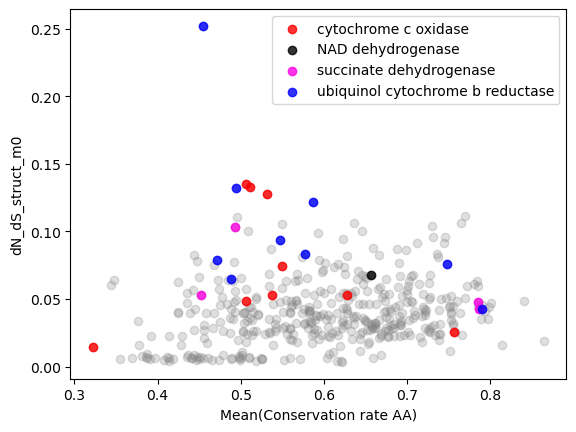

In [73]:
fig, ax = plt.subplots(1,1)

enzymes = {'cytochrome c oxidase': 'r',
           'NAD dehydrogenase': 'k',
           'succinate dehydrogenase': '#fc03e3', 
           'ubiquinol cytochrome b reductase': 'b'
          }

ax.scatter(struct_data_dnds['Mean(Conservation rate AA)'], struct_data_dnds['dN_dS_struct_m0'], alpha = 0.25, c= 'grey')

legend_handles = []
legend_labels = []
for enzyme, color in enzymes.items(): 
    print(enzyme)
    print(color)
    struct_data_dnds_subset = struct_data_dnds[struct_data_dnds['og_ref'].isin(etc_proteins_clustered[etc_proteins_clustered['enzyme']==enzyme]['og_ref'])]
    handle = ax.scatter(struct_data_dnds_subset['Mean(Conservation rate AA)'], struct_data_dnds_subset['dN_dS_struct_m0'],color=color ,alpha = 0.8)
    legend_handles.append(handle)
    legend_labels.append(enzyme)
    
ax.set_ylabel('dN_dS_struct_m0')
ax.set_xlabel('Mean(Conservation rate AA)')
ax.legend(legend_handles, legend_labels)

Text(0.5, 0, 'Mean(Conservation rate AA)')

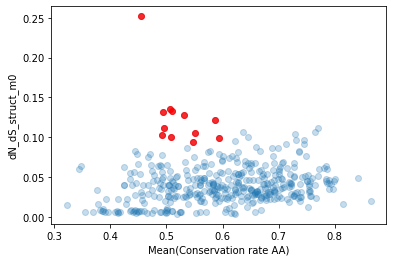

In [40]:
fig, ax = plt.subplots(1,1)

ax.scatter(struct_data_dnds['Mean(Conservation rate AA)'], struct_data_dnds['dN_dS_struct_m0'], alpha = 0.25)

struct_data_dnds_subset = struct_data_dnds[(struct_data_dnds['dN_dS_struct_m0']>0.09)&(struct_data_dnds['Mean(Conservation rate AA)']<0.6)]

ax.scatter(struct_data_dnds_subset['Mean(Conservation rate AA)'], struct_data_dnds_subset['dN_dS_struct_m0'],color='r' ,alpha = 0.8)
ax.set_ylabel('dN_dS_struct_m0')
ax.set_xlabel('Mean(Conservation rate AA)')

In [47]:
struct_data_dnds[(struct_data_dnds['dN_dS_struct_m0']>0.08)&(struct_data_dnds['Mean(Conservation rate AA)']>0.6)].sort_values(by='dN_dS_struct_m0', ascending=False).loc[:,['og_ref','og','dN_dS_struct_m0', 'Mean(Conservation rate AA)']]

,og_ref,og,dN_dS_struct_m0,Mean(Conservation rate AA)
4,OG1145_REF_Scer_AF-P00358-F1-model_v2,OG1145,0.11116,0.769694
22,OG1193_REF_Scer_AF-P00924-F1-model_v2,OG1193,0.10633,0.765119
38,OG1208_REF_Scer_AF-P04806-F1-model_v2,OG1208,0.10633,0.636346
44,OG1813_REF_Scer_AF-P05694-F1-model_v2,OG1813,0.10394,0.729674
11,OG3185_REF_Scer_AF-P00447-F1-model_v2,OG3185,0.10029,0.645687
125,OG1432_REF_Scer_AF-P14540-F1-model_v2,OG1432,0.09617,0.730782
14,OG1424_REF_Scer_AF-P00560-F1-model_v2,OG1424,0.09583,0.745608
173,OG1112_REF_Scer_AF-P23254-F1-model_v2,OG1112,0.09457,0.622696
28,OG2794_REF_Scer_AF-P00950-F1-model_v2,OG2794,0.09144,0.744687
68,OG1892_REF_Scer_AF-P07262-F1-model_v2,OG1892,0.09138,0.712552


Text(0.5, 0, 'Mean(Conservation rate AA)')

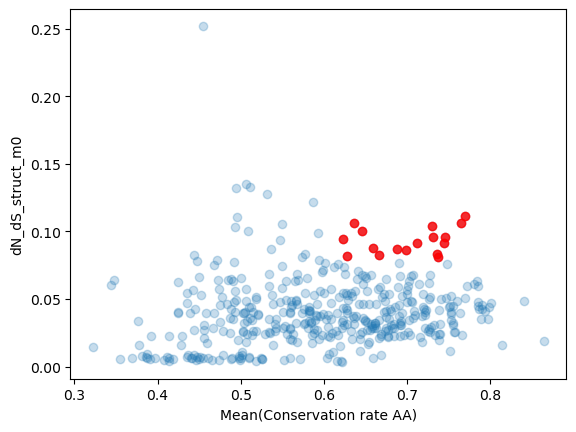

In [47]:
fig, ax = plt.subplots(1,1)

ax.scatter(struct_data_dnds['Mean(Conservation rate AA)'], struct_data_dnds['dN_dS_struct_m0'], alpha = 0.25)

struct_data_dnds_subset = struct_data_dnds[(struct_data_dnds['dN_dS_struct_m0']>0.08)&(struct_data_dnds['Mean(Conservation rate AA)']>0.6)].sort_values(by='dN_dS_struct_m0', ascending=False).loc[:,['og_ref','og','dN_dS_struct_m0', 'Mean(Conservation rate AA)']]

ax.scatter(struct_data_dnds_subset['Mean(Conservation rate AA)'], struct_data_dnds_subset['dN_dS_struct_m0'],color='r' ,alpha = 0.8)
ax.set_ylabel('dN_dS_struct_m0')
ax.set_xlabel('Mean(Conservation rate AA)')

1145: TDH3, TDH1,    
1193: ERR3, ERR2, ENO1, ERR1, ENO2,     
1208: HKX2, HKX1
1813: MET6
OG3185: SOD2
OG1432: FBA1
OG1424: PGK1
OG1112: TKL1, TKL2
OG2794: GPM1
OG1892: GDH1, GDH3


In [62]:
struct_data_dnds[(struct_data_dnds['dN_dS_struct_m0']<0.006)&(struct_data_dnds['Mean(Conservation rate AA)']<0.6)].sort_values(by='dN_dS_struct_m0', ascending=False).loc[:,['og_ref','og','dN_dS_struct_m0', 'Mean(Conservation rate AA)']]

,og_ref,og,dN_dS_struct_m0,Mean(Conservation rate AA)
272,OG2262_REF_Scer_AF-P37254-F1-model_v2,OG2262,0.00599,0.488731
84,OG3445_REF_Scer_AF-P08432-F1-model_v2,OG3445,0.00593,0.571035
417,OG2228_REF_Scer_AF-P53037-F1-model_v2,OG2228,0.00572,0.525051
511,OG3679_REF_Scer_AF-Q12051-F1-model_v2,OG3679,0.00565,0.449906
73,OG3065_REF_Scer_AF-P07285-F1-model_v2,OG3065,0.00549,0.525262
239,OG1168_REF_Scer_AF-P32528-F1-model_v2,OG1168,0.00543,0.390285
292,OG4021_REF_Scer_AF-P38242-F1-model_v2,OG4021,0.00533,0.407698
140,OG1673_REF_Scer_AF-P16661-F1-model_v2,OG1673,0.00518,0.499541
441,OG3104_REF_Scer_AF-P53954-F1-model_v2,OG3104,0.00518,0.464948
318,OG3074_REF_Scer_AF-P38913-F1-model_v2,OG3074,0.00510,0.446412


In [7]:
struct_data_lc_hdnds = struct_data_dnds[(struct_data_dnds['dN_dS_struct_m0']>0.09)&(struct_data_dnds['Mean(Conservation rate AA)']<0.6)].sort_values(by='dN_dS_struct_m0', ascending=False).loc[:,['og_ref','og','dN_dS_struct_m0', 'Mean(Conservation rate AA)']]
struct_data_lc_ldnds = struct_data_dnds[(struct_data_dnds['dN_dS_struct_m0']<0.006)&(struct_data_dnds['Mean(Conservation rate AA)']<0.6)].sort_values(by='dN_dS_struct_m0', ascending=False).loc[:,['og_ref','og','dN_dS_struct_m0', 'Mean(Conservation rate AA)']]
struct_data_hc_hdnds = struct_data_dnds[(struct_data_dnds['dN_dS_struct_m0']>0.08)&(struct_data_dnds['Mean(Conservation rate AA)']>0.6)].sort_values(by='dN_dS_struct_m0', ascending=False).loc[:,['og_ref','og','dN_dS_struct_m0', 'Mean(Conservation rate AA)']]

og_refs = {'low_cons_high_dn_ds': struct_data_lc_hdnds['og_ref'], 
           'low_cons_low_dn_ds': struct_data_lc_ldnds['og_ref'],
           'high_cons_high_dn_ds': struct_data_hc_hdnds['og_ref']
          }

## Make Plots of Bayes Empirical Bayes probabilities for residue


In [3]:
#Import BEB data from file
og_ref = 'OG1122_REF_Scer_AF-P13711-F1-model_v2'

#G:\My Drive\Crick_LMS\projects\diverse_yeasts\alphafold\selection_calculations\branch_site\OG1122_REF_Scer_AF-P13711-F1-model_v2\A
bs_rst_file = base_dir + os.sep + os.path.normpath('selection_calculations/branch_site/' + og_ref + '/A/rst')

beb_vals = extract_beb_values(bs_rst_file)

In [4]:
tree_ids = {1: '41..42',
             2: '41..42 and below',
             3: '43..44',
             4: '44..45',
             5: '45..46', 
             6: '47..48',
             7: '47..48 and below',
             8: '57..60',
             9: '36..68'
            }



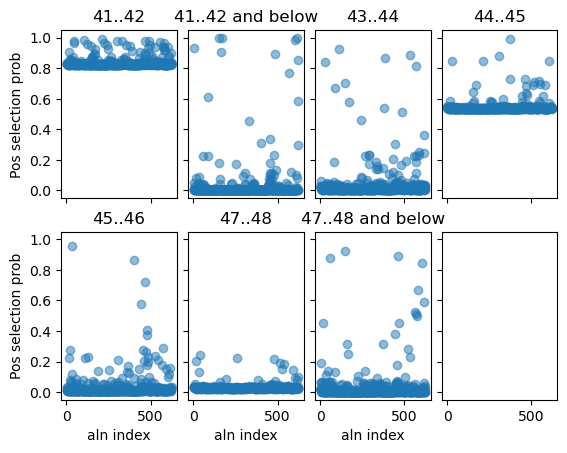

In [6]:
fig, axarr = plt.subplots(2,4, sharex=True, sharey=True)

trees_to_plot = [1,2,3,4,5,6,7]

n_plot = 0

for jj, axarr_col in enumerate(axarr):
    for kk, ax in enumerate(axarr_col):
        if n_plot<len(trees_to_plot):
            tree_ind = trees_to_plot[n_plot]
            ax.scatter(beb_vals[tree_ind].index, beb_vals[tree_ind]['class_2'], alpha=0.5)
            ax.set_title(tree_ids[tree_ind])
            
            if jj == 1: 
                ax.set_xlabel('aln index')
            if kk == 0: 
                ax.set_ylabel('Pos selection prob')
            n_plot = n_plot + 1
        
fig.subplots_adjust(hspace=0.2, wspace=0.1)

Text(0, 0.5, 'Positive selection probability')

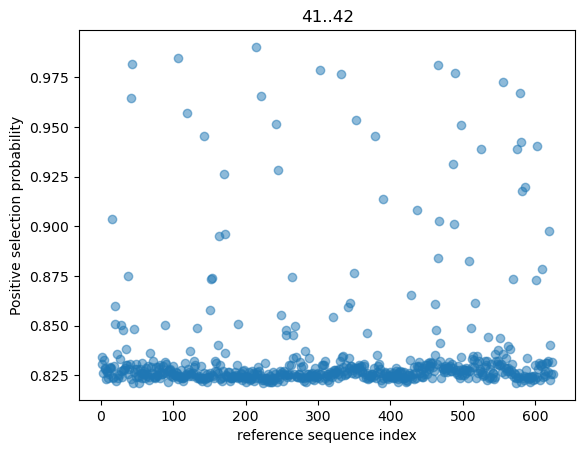

In [7]:
fig, ax = plt.subplots()

tree_ind = 1
ax.scatter(beb_vals[tree_ind].index, beb_vals[tree_ind]['class_2'], alpha=0.5)
ax.set_title(tree_ids[tree_ind])
 
ax.set_xlabel('reference sequence index')
ax.set_ylabel('Positive selection probability')


## For a given Tree, extract residues of interest in terms of both the Ref sequence (usually S. cerevisiae) and Ref Sequence coordinates

In [9]:
tree_no = 8
beb_vals_tree = beb_vals[tree_no]
beb_vals_filt = beb_vals_tree[beb_vals_tree['class_2']>0.90]
residues_of_interest = list(zip(beb_vals_filt.index,beb_vals_filt['ref_AA']))

In [11]:
## Extract SC coordinates with coordinates from the trimmed alignment
og_ref = 'OG1122_REF_Scer_AF-P13711-F1-model_v2'

ref_res_of_int, aln_res_of_int, ref_seq = identify_ref_residue(og_ref, residues_of_interest)
print(ref_res_of_int)
print(aln_res_of_int)


['Y408', 'A418', 'I452', 'F640']
['Y974', 'A984', 'I1022', 'F1229']


In [ ]:
OG4552_REF_Scer_AF-P37299-F1-model_v2 OG4555_REF_Scer_AF-P32799-F1-model_v2

## Get list of ETC Proteins

From pathways: aerobic respiration, electron transport chain

Cytochrome C oxidase: 
Cox13, 12, 9, 8, 7, 6, 5A, 4, 3, 2, 1
COB (Mito), RIP1, CYT1, COR1, QCR22, QCR6, QCR7, QCR8, QCR9, QCR10

Succinate Dehydrogenase: 
SDH4, 3, 2, SDH9 , SDH1

YJL045W is the gene name of SDH9 and is what was listed

NADH Dehydrogenase
NDI1
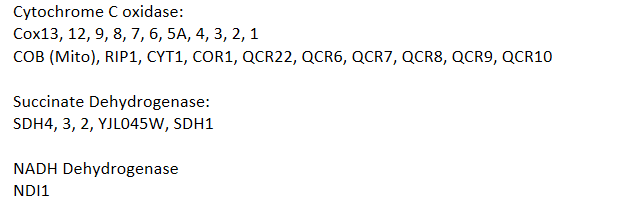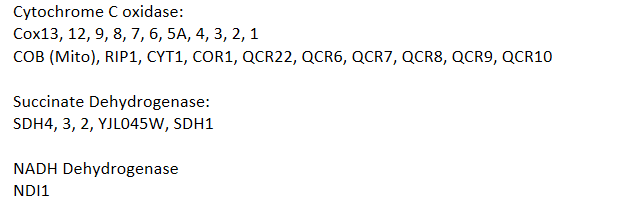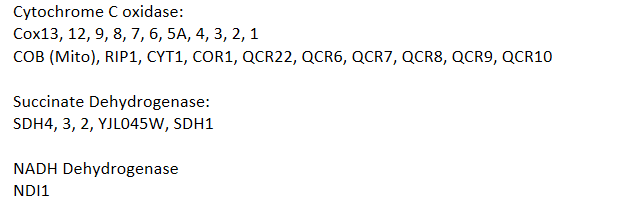

In [38]:
struct_data_dnds

,Unnamed: 0,og_x,og_ref,Mean(Mapping rate),Mean(Conservation rate AA),Mean(Conservation rate Type),OG_SCE,dN_dS_SCE,OG_nl_02_03,dN_dS_nl_02_03,dN_dS_struct,dN_struct,dS_struct,og_y
0,0,OG4352,OG4352_REF_Scer_AF-P00127-F1-model_v2,0.515006,0.488312,0.583829,OG4352.out_yn00,0.0924,OG4352.out_yn00,0.11860,0.1301,0.30970,2.7347,OG4352
1,1,OG3208,OG3208_REF_Scer_AF-P00128-F1-model_v2,0.983085,0.577829,0.742639,OG3208.out_yn00,0.1655,OG3208.out_yn00,0.14910,0.2197,0.40350,1.8272,OG3208
2,2,OG1016,OG1016_REF_Scer_AF-P00330-F1-model_v2,0.954863,0.736954,0.817145,NaN,NaN,NaN,NaN,0.1130,0.19800,1.7722,OG1016
3,3,OG1016,OG1016_REF_Scer_AF-P00331-F1-model_v2,0.938285,0.737345,0.817970,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,OG1145,OG1145_REF_Scer_AF-P00358-F1-model_v2,0.994326,0.769694,0.856194,NaN,NaN,OG1145.out_yn00,0.09955,0.1600,0.18535,1.2456,OG1145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545,545,NaN,OG6290_eremothecium_gossypii__OG6290__40_1372,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,OG6290
546,546,NaN,OG6574_eremothecium_gossypii__OG6574__40_137,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.2330,0.45360,1.9462,OG6574
547,547,NaN,OG6598_kazachstania_naganishii__OG6598__49_1006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,OG6598
548,548,NaN,OG7278_kazachstania_naganishii__OG7278__49_2415,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.3026,0.67650,2.0996,OG7278


In [43]:
etc_pathways_list = {'cytochrome c oxidase': ['COX1', 'COX2', 'COX3', 'COX4', 'COX5A', 'COX6', 'COX7', 'COX8', 'COX9', 'COX12', 'COX13', 'COX26'],  #COX26 not present in pathways, but is a subunit
                 'ubiquinol cytochrome b reductase': ['COB', 'RIP1', 'CYT1', 'COR1', 'QCR2', 'QCR6', 'QCR7', 'QCR8', 'QCR9', 'QCR10'],
                 'succinate dehydrogenase': ['SDH4', 'SDH3', 'SDH2', 'SDH9', 'SDH1'], #SDH3 and #SDH9was not present in my version of the SGD name lookup
                 'NAD dehydrogenase': ['NDI1']
                }

mito_list = ['COB', 'COX1', 'COX2', 'COX3']

paralog_pairs = [('COX5B','COX5A'), ('SHH3','SDH3'),('SDH9', 'SDH1'),('SHH4','SDH4')]

paralog_lookup = {}
for p1,p2 in paralog_pairs: 
    paralog_lookup[p1] = p2
for p1,p2 in paralog_pairs: 
    paralog_lookup[p2] = p1

og_fname = base_dir + os.sep + os.path.normpath('selected_proteins/og_metadata.json')
with open(og_fname, 'r') as f:
    og_metadata = json.load(f) 

model_og_lookup = dyt.load_model_og_lookup()


etc_name_list = []
for enzyme, name_list in etc_pathways_list.items(): 
    etc_name_list = etc_name_list + name_list

etc_name_list = etc_name_list + [paralog for paralog in paralog_lookup.keys()]
etc_name_list = list(set(etc_name_list))
etc_orf_list = yeast_esr_exp.SC_orf_lookup_by_name(etc_name_list)

newer_genes = {'SDH3': 'YKL141W',
               'SDH9': 'YJL045W'
              }

etc_orf_list_updated = []
for orf in etc_orf_list: 
    if orf in newer_genes.keys(): 
        etc_orf_list_updated.append(newer_genes[orf])
    else: 
        etc_orf_list_updated.append(orf)     

etc_og_list = []

for gene_id in etc_orf_list_updated: 
    if gene_id in model_og_lookup['Scer'].keys():
        etc_og_list.append(model_og_lookup['Scer'][gene_id])
    else: 
        etc_og_list.append(None)

paralogs_col =[]
for name in etc_name_list: 
    if name in paralog_lookup.keys():
        paralogs_col.append(paralog_lookup[name])
    else: 
        paralogs_col.append(None)

#Check if the OG was selected
og_retained = []
for og in etc_og_list: 
    if og in og_metadata.keys(): 
        og_data = og_metadata[og]
        if og_data['pass_species_filter']: 
            og_retained.append(True)
        else: 
            og_retained.append(False)
    else: 
        og_retained.append(False)
        
#mitochondrial
mitochondrial = []
for gene_id in etc_orf_list_updated: 
    if gene_id[0]=='Q': 
        mitochondrial.append(True)
    else: 
        mitochondrial.append(False)
        
etc_proteins_df = pd.DataFrame.from_dict( {'name': etc_name_list, 
                         'gene_id': etc_orf_list_updated,
                         'og': etc_og_list, 
                         'paralog': paralogs_col,
                         'og_retained': og_retained, 
                         'mitochondrial': mitochondrial
                        })

#Check if any of these break apart in clusters and identify appropriate og_ref id
cluster_table = pd.read_csv(base_dir + os.sep + os.path.normpath('msas/structural/tm_align/clustering/cluster_mapping.csv'))
cluster_table['og'] = [og_clust.split('_')[0] for og_clust in cluster_table['og_clust']]
cluster_table_subset = cluster_table[(cluster_table['cluster_rep']==1) & (cluster_table['og'].isin(etc_proteins_df['og']))]

etc_proteins_clustered = cluster_table_subset.merge(etc_proteins_df, how='outer', on='og').loc[:,['primary_id', 'og_clust', 'og', 'name', 'gene_id', 'paralog', 'og_retained', 'no_sc', 'mitochondrial']]

#assign enzyme_name

enzyme_lookup = {}
for enzyme, gene_list in etc_pathways_list.items(): 
    for gene in gene_list: 
        enzyme_lookup[gene] = enzyme
        
#assigns enzyme name to match paralog
for p1,p2 in paralog_lookup.items(): 
    if not(p1) in enzyme_lookup.keys(): 
        enzyme_lookup[p1] = enzyme_lookup[p2]

enzyme_col = []
for name in etc_proteins_clustered['name']: 
    if name in enzyme_lookup.keys(): 
        enzyme_col.append(enzyme_lookup[name])
    else: 
        enzyme_col.append(None)
        
etc_proteins_clustered['enzyme'] = enzyme_col

#Include conservation rate and DN_DS
struct_data_dnds = pd.read_csv(base_dir + os.sep + os.path.normpath('selection_calculations/m0/m0_struct_neilsen_yn00.csv'), index_col=0)
etc_proteins_clustered = etc_proteins_clustered.merge(struct_data_dnds.loc[:,['og_ref', 'Mean(Conservation rate AA)', 'Mean(Mapping rate)', 'dN_dS_struct_m0']], how='left', left_on='primary_id', right_on='og_ref')

etc_proteins_clustered.to_csv(base_dir + os.sep + os.path.normpath('examples/etc/etc_table.csv'))

S.Cer orf for SDH9not found


## For a given set of og_ref which have had M1 analysis performed, generate trees to test. 
Also for those trees to test extracts information about the branches - which species and proteins are covered. 


In [17]:
new_etc = {'COX12': 'OG1254_REF_Scer_AF-Q01519-F1-model_v2', 
               'SDH9_SDH1': 'OG1275_REF_Scer_AF-P47052-F1-model_v2',
               'SHH4_SDH4': 'OG1287_REF_Scer_AF-P37298-F1-model_v2',
               'QCR2': 'OG2006_REF_Scer_AF-P07257-F1-model_v2',
               'CYT1': 'OG2248_REF_Scer_AF-P07143-F1-model_v2',
               'SDH2': 'OG2704_REF_Scer_AF-P21801-F1-model_v2',
               'COX6': 'OG2714_REF_Scer_AF-P00427-F1-model_v2',
               'QCR7': 'OG3208_REF_Scer_AF-P00128-F1-model_v2',
               'COX4': 'OG3505_REF_Scer_AF-P04037-F1-model_v2',
               'RIP1': 'OG3575_REF_Scer_AF-P08067-F1-model_v2',
               'COX9': 'OG4118_REF_Scer_AF-P07255-F1-model_v2',
               'QCR6': 'OG4352_REF_Scejr_AF-P00127-F1-model_v2',
               'COX8': 'OG4751_REF_Scer_AF-P04039-F1-model_v2',
               'NDI1': 'OG5490_REF_Scer_AF-P32340-F1-model_v2',
               'COX2': 'OG4755_kluyveromyces_marxianus__OG4755__51_759', #MItochondrial, shouldn't have been retained
               'COB': 'OG5006_kluyveromyces_marxianus__OG5006__51_4218'
          }

In [18]:
' '.join(new_etc.values())

'OG1254_REF_Scer_AF-Q01519-F1-model_v2 OG1275_REF_Scer_AF-P47052-F1-model_v2 OG1287_REF_Scer_AF-P37298-F1-model_v2 OG2006_REF_Scer_AF-P07257-F1-model_v2 OG2248_REF_Scer_AF-P07143-F1-model_v2 OG2704_REF_Scer_AF-P21801-F1-model_v2 OG2714_REF_Scer_AF-P00427-F1-model_v2 OG3208_REF_Scer_AF-P00128-F1-model_v2 OG3505_REF_Scer_AF-P04037-F1-model_v2 OG3575_REF_Scer_AF-P08067-F1-model_v2 OG4118_REF_Scer_AF-P07255-F1-model_v2 OG4352_REF_Scer_AF-P00127-F1-model_v2 OG4751_REF_Scer_AF-P04039-F1-model_v2 OG5490_REF_Scer_AF-P32340-F1-model_v2 OG4755_kluyveromyces_marxianus__OG4755__51_759 OG5006_kluyveromyces_marxianus__OG5006__51_4218'

In [26]:
etc_og_refs = {'COX13': 'OG4555_REF_Scer_AF-P32799-F1-model_v2', #ones with higher positive selection and lower conservation
               'COX5A_COX5B': 'OG4316_REF_Scer_AF-P00424-F1-model_v2',
               'COR1': 'OG4150_REF_Scer_AF-P07256-F1-model_v2',
               'COX7': 'OG4346_REF_Scer_AF-P10174-F1-model_v2',
               'QCR8': 'OG4360_REF_Scer_AF-P08525-F1-model_v2',
               'SHH3_SDH3': 'OG2112_REF_Scer_AF-P33421-F1-model_v2',
               'QCR9': 'OG4744_REF_Scer_AF-P22289-F1-model_v2',
               'QCR10': 'OG4552_REF_Scer_AF-P37299-F1-model_v2',
               'COX12': 'OG1254_REF_Scer_AF-Q01519-F1-model_v2', #Others
               'SDH9_SDH1': 'OG1275_REF_Scer_AF-P47052-F1-model_v2',
               'SHH4_SDH4': 'OG1287_REF_Scer_AF-P37298-F1-model_v2',
               'QCR2': 'OG2006_REF_Scer_AF-P07257-F1-model_v2',
               'CYT1': 'OG2248_REF_Scer_AF-P07143-F1-model_v2',
               'SDH2': 'OG2704_REF_Scer_AF-P21801-F1-model_v2',
               'COX6': 'OG2714_REF_Scer_AF-P00427-F1-model_v2',
               'QCR7': 'OG3208_REF_Scer_AF-P00128-F1-model_v2',
               'COX4': 'OG3505_REF_Scer_AF-P04037-F1-model_v2',
               'RIP1': 'OG3575_REF_Scer_AF-P08067-F1-model_v2',
               'COX9': 'OG4118_REF_Scer_AF-P07255-F1-model_v2',
               'QCR6': 'OG4352_REF_Scer_AF-P00127-F1-model_v2',
               'COX8': 'OG4751_REF_Scer_AF-P04039-F1-model_v2',
               'NDI1': 'OG5490_REF_Scer_AF-P32340-F1-model_v2',
               #'COX2': 'OG4755_kluyveromyces_marxianus__OG4755__51_759', #MItochondrial, shouldn't have been retained
               #'COB': 'OG5006_kluyveromyces_marxianus__OG5006__51_4218'
}

In [27]:
dn_ds_thresh = 1.1 
max_branches_to_test = 17



marked_tree_branch_info = {}
hits_tables = {}
branch_leaves = {}

for goi, og_ref in etc_og_refs.items(): 
    print(goi)
    #Load tree with node labels
    m1_rst_fname = base_dir + os.sep + os.path.normpath('selection_calculations/m1/' + og_ref + '/rst')
    tree_node_labels = dyt.load_tree_with_node_labels(m1_rst_fname)

    #Load table of M1 values
    m1_fname = base_dir + os.sep + os.path.normpath('selection_calculations/m1/' + og_ref + '/M1.out')
    dn_ds_table = dyt.load_dn_ds_m1(m1_fname)
    
    #Load map of og names
    og_name_map_fname = base_dir + os.sep + os.path.normpath('msas/structural/tm_align/seq_name_map/' + og_ref + '.tm.tsv')
    og_name_map = pd.read_table(og_name_map_fname)
    
    #Identify Nodes with high DN/DS
    hits_table = dn_ds_table[dn_ds_table['dN/dS']>dn_ds_thresh].sort_values(by='dN/dS', ascending=False)
    print('Total branches above threshold: ' + str(len(hits_table)))
    if len(hits_table)>max_branches_to_test: 
        print('More than ' + str(max_branches_to_test) + ' candidate branches for positive selection, selecting top ' + str(max_branches_to_test) + '. og_ref: ' + og_ref)
        branches_to_test = hits_table.index[0:12]
    else: 
        branches_to_test = hits_table.index

    hits_table = hits_table.loc[branches_to_test] # truncate hits table
    
    nodes_to_label = [branch.split('..')[1] for branch in hits_table.index]
    
    hits_table['labelled_node'] = nodes_to_label
    
    hits_tables[goi] = hits_table

    #Make file with trees labeling the indicated branches
    labeled_trees_fname = base_dir + os.sep + os.path.normpath('selection_calculations/branch_site/trees/' + og_ref + '.bs_trees')

    marked_tree_branch_info_goi = dyt.write_marked_trees(labeled_trees_fname, tree_node_labels, nodes_to_label)
    marked_tree_branch_info[goi] = marked_tree_branch_info_goi
    
    branch_leaves_goi = {}
    for jj, selected_node_name in enumerate(nodes_to_label): 
        tree_no = jj + 1
        branch_leaves_goi[tree_no] = dyt.get_branch_leaves(tree_node_labels, selected_node_name, og_name_map, marked_tree_branch_info_goi)
    branch_leaves[goi] = branch_leaves_goi

COX13
Total branches above threshold: 6
COX5A_COX5B
Total branches above threshold: 10
COR1
Total branches above threshold: 8
COX7
Total branches above threshold: 15
QCR8
Total branches above threshold: 9
SHH3_SDH3
Total branches above threshold: 16
QCR9
Total branches above threshold: 11
QCR10
Total branches above threshold: 11
COX12
Total branches above threshold: 13
SDH9_SDH1
Total branches above threshold: 12
SHH4_SDH4
Total branches above threshold: 14
QCR2
Total branches above threshold: 12
CYT1
Total branches above threshold: 9
SDH2
Total branches above threshold: 10
COX6
Total branches above threshold: 11
QCR7
Total branches above threshold: 17
COX4
Total branches above threshold: 8
RIP1
Total branches above threshold: 10
COX9
Total branches above threshold: 12
QCR6
Total branches above threshold: 8
COX8
Total branches above threshold: 13
NDI1
Total branches above threshold: 4


## Check Branch-Site Analysis results
Branch Site Analysis is then performed on those trees (on cluster) 

Extracts output data from the Branch Site Analysis results.

The output for each protein is a json file 

gene_name: 
    og_ref
    Tree_number: 
        branch_label: 
        labelled_node: 
        branch_site_stats: 
            m1_dnds: dnds value for the indicated branch from the m1 run
            m1_dn: dn value from m1 run
            m1_ds: ds value from m1 run
            mlA: Maximum Likelihood estimator for modelA
            mlAfix1: Maximum Likelihood estimator for modelA_fix1
            bs_stat: statistic for chi2 test, 2*(mlA-mlAfix1)
            sig_flag: If the statistic is above the chi2 threshold         
        site_data: 
            pos_sel_res_paml: identity and index of residues that pass the threshold from the PAML output - residue is from first sequence in alignment and index is from the strict trimming
            pos_sel_res_aln: identity and index of residues that pass the threshold from the alignment
            pos_sel_res_ref: identity and index of residues that pass the threshold from the reference protein from the alignment (usually SC)
            beb_score: beb score for residues that pass the threshold.  
        leaf_data: 
            leaves_short: a list of proteins (abbreviated name)
            leaves_long:  a list of proteins (full name)
            specs_unique: a list of species  
            paralogs_flag: true if there are paralogs in that branch

In [28]:
chi2_thresh = 3.84  # Chi2 with 50:50 mixture of point mass 0 has critical values of 5% at 2.71 and 5.41 at 1%.   (page 30 of manual)
                    # Normal Chi2 has critical values 3.84 and 5.99 this is what they recommend
                    # Would also need to do Multiple Hypothesis test

beb_val_thresh = 0.95 #Bayes Empirical value for probability that a residue is positively selected.  Sometimes this value has a high baseline.  

bs_analysis_data = {
            'chi2_thresh': chi2_thresh,
            'beb_val_thresh': beb_val_thresh
}


for goi, og_ref in etc_og_refs.items(): 
    print(goi)
    bs_analysis_data_goi = {}
    og_ref = etc_og_refs[goi]

    bs_rst_file = base_dir + os.sep + os.path.normpath('selection_calculations/branch_site/' + og_ref + '/A/rst')
    beb_vals = dyt.extract_beb_values(bs_rst_file)

    bsa_dir = base_dir + os.sep + os.path.normpath('selection_calculations/branch_site/' + og_ref)

    #def BS_comparison(bsa_dir)
    #Output:  Dictionary for each tree that contains MSA, MSA_fix1, Difference, and whether it passes the threshold

    bsa_fname = bsa_dir + os.sep + os.path.normpath('A/BSA.out')

    ml_data_A = dyt.extract_ML_est_BS(bsa_fname)

    bsafix1_fname = bsa_dir + os.sep + os.path.normpath('Afix1/BSAfix1.out')
    ml_data_Afix1 = dyt.extract_ML_est_BS(bsafix1_fname)


    for jj, (tree_no, ml_data_A_tree) in enumerate(ml_data_A.items()):
        mlA = ml_data_A_tree[0]
        mlAfix1 = ml_data_Afix1[tree_no][0]
        bs_analysis_data_goi[tree_no] = {'branch_site_stats': 
                                               {
                                                   'mlA': mlA, 
                                                   'mlAfix1': mlAfix1,
                                                   'bs_stat': 2*(mlA-mlAfix1),
                                                   'sig_flag': 2*(mlA-mlAfix1)>chi2_thresh
                                               }
                                        }

    for jj, (branch, row) in enumerate(hits_tables[goi].iterrows()): 
        tree_no = jj+1
        bs_analysis_data_goi[tree_no]['branch_label'] = branch
        bs_analysis_data_goi[tree_no]['labelled_node'] = row['labelled_node']
        bs_analysis_data_goi[tree_no]['branch_site_stats']['m1_dnds'] = row['dN/dS']
        bs_analysis_data_goi[tree_no]['branch_site_stats']['m1_dn'] = row['dN']
        bs_analysis_data_goi[tree_no]['branch_site_stats']['m1_ds'] = row['dS']

    #For each tree add leaf data from bs_analysis_data_goi and extract beb values to identify residues of interest
    for tree_no, branch_leaves_tree in branch_leaves[goi].items():
        bs_analysis_data_goi[tree_no]['leaf_data'] = branch_leaves_tree

        beb_vals_tree = beb_vals[tree_no]
        beb_vals_filt = beb_vals_tree[beb_vals_tree['class_2']>beb_val_thresh]
        residues_of_interest = list(zip(beb_vals_filt.index,beb_vals_filt['ref_AA']))
        pos_sel_res_ref, pos_sel_res_aln, ref_seq = dyt.identify_ref_residue(og_ref, residues_of_interest)

        bs_analysis_data_goi[tree_no]['site_data'] = {
              'pos_sel_res_paml': [ind_res[1] + str(ind_res[0]) for ind_res in residues_of_interest], ####
              'pos_sel_res_aln': pos_sel_res_aln,
              'pos_sel_res_ref': pos_sel_res_ref,
              'beb_score': list(beb_vals_filt['class_2'])
            }
        
    bs_analysis_data[goi] = bs_analysis_data_goi

COX13
COX5A_COX5B
check convergence flag, tree number 2 in G:\My Drive\Crick_LMS\projects\diverse_yeasts\alphafold\selection_calculations\branch_site\OG4316_REF_Scer_AF-P00424-F1-model_v2\Afix1\BSAfix1.out
COR1
COX7
check convergence flag, tree number 1 in G:\My Drive\Crick_LMS\projects\diverse_yeasts\alphafold\selection_calculations\branch_site\OG4346_REF_Scer_AF-P10174-F1-model_v2\Afix1\BSAfix1.out
check convergence flag, tree number 8 in G:\My Drive\Crick_LMS\projects\diverse_yeasts\alphafold\selection_calculations\branch_site\OG4346_REF_Scer_AF-P10174-F1-model_v2\Afix1\BSAfix1.out
QCR8
SHH3_SDH3
check convergence flag, tree number 6 in G:\My Drive\Crick_LMS\projects\diverse_yeasts\alphafold\selection_calculations\branch_site\OG2112_REF_Scer_AF-P33421-F1-model_v2\Afix1\BSAfix1.out
QCR9
check convergence flag, tree number 6 in G:\My Drive\Crick_LMS\projects\diverse_yeasts\alphafold\selection_calculations\branch_site\OG4744_REF_Scer_AF-P22289-F1-model_v2\Afix1\BSAfix1.out
QCR10
COX12


QCR6
check convergence flag, tree number 6 in G:\My Drive\Crick_LMS\projects\diverse_yeasts\alphafold\selection_calculations\branch_site\OG4352_REF_Scer_AF-P00127-F1-model_v2\A\BSA.out
check convergence flag, tree number 6 in G:\My Drive\Crick_LMS\projects\diverse_yeasts\alphafold\selection_calculations\branch_site\OG4352_REF_Scer_AF-P00127-F1-model_v2\Afix1\BSAfix1.out
check convergence flag, tree number 7 in G:\My Drive\Crick_LMS\projects\diverse_yeasts\alphafold\selection_calculations\branch_site\OG4352_REF_Scer_AF-P00127-F1-model_v2\Afix1\BSAfix1.out
COX8
check convergence flag, tree number 12 in G:\My Drive\Crick_LMS\projects\diverse_yeasts\alphafold\selection_calculations\branch_site\OG4751_REF_Scer_AF-P04039-F1-model_v2\A\BSA.out
check convergence flag, tree number 10 in G:\My Drive\Crick_LMS\projects\diverse_yeasts\alphafold\selection_calculations\branch_site\OG4751_REF_Scer_AF-P04039-F1-model_v2\Afix1\BSAfix1.out
NDI1


In [29]:
# Save bs_analysis_data
bs_analysis_data_fname = base_dir + os.sep + os.path.normpath('selection_calculations/branch_site/etc_bs_analysis.json')

with open(bs_analysis_data_fname, 'w') as f:
    json.dump(bs_analysis_data, f, sort_keys=True, indent=4 )

# Load Branch Site Analysis data of ETC proteins and extract metadata

In [30]:
bs_analysis_data_fname = base_dir + os.sep + os.path.normpath('selection_calculations/branch_site/etc_bs_analysis.json')

with open(bs_analysis_data_fname, 'r') as f:
    bs_analysis_data = json.load(f)

In [31]:
#For each ETC Protein, extract a list of positively selected values

pos_sel_res = {}

for goi, og_ref in etc_og_refs.items(): 
    pos_sel_res_goi = {}
    pos_sel_res_goi['og_ref'] = og_ref
    pos_sel_res_goi_res = []
    
    bs_analysis_goi = bs_analysis_data[goi]
    for tree, bs_analysis_goi_tree in bs_analysis_goi.items():
        if bs_analysis_goi_tree['branch_site_stats']['sig_flag']:
            pos_sel_res_goi_res = pos_sel_res_goi_res + bs_analysis_goi_tree['site_data']['pos_sel_res_ref']
    pos_sel_res_goi['selected_residues'] = pos_sel_res_goi_res
            
    pos_sel_res[goi] = pos_sel_res_goi

# Save bs_analysis_data
bs_analysis_selres_fname = base_dir + os.sep + os.path.normpath('selection_calculations/branch_site/etc_bs_selected_res.json')

with open(bs_analysis_selres_fname, 'w') as f:
    json.dump(pos_sel_res, f, sort_keys=True, indent=4 )
    
    
# with open(bs_analysis_selres_fname, 'r') as f:
#     pos_sel_res = json.load(f)

In [69]:
pos_sel_res

{'COX13': {'og_ref': 'OG4555_REF_Scer_AF-P32799-F1-model_v2',
  'selected_residues': ['A67', 'S55', 'A78', 'H86']},
 'COX5A_COX5B': {'og_ref': 'OG4316_REF_Scer_AF-P00424-F1-model_v2',
  'selected_residues': ['A30',
   'D48',
   'E55',
   'Q57',
   'W73',
   'K89',
   'S138',
   'Y135']},
 'COR1': {'og_ref': 'OG4150_REF_Scer_AF-P07256-F1-model_v2',
  'selected_residues': ['Y104',
   'W260',
   'S453',
   'S108',
   'G210',
   'L219',
   'N221',
   'K235',
   'V265',
   'D304',
   'A366',
   'S368',
   'L372',
   'T414',
   'D417',
   'I433',
   'M452',
   'N67',
   'F285',
   'L372',
   'L390',
   'I448',
   'V144',
   'T172',
   'E186',
   'S222',
   'Q298',
   'Q373']},
 'COX7': {'og_ref': 'OG4346_REF_Scer_AF-P10174-F1-model_v2',
  'selected_residues': ['W21',
   'L30',
   'A35',
   'T43',
   'L46',
   'P49',
   'N50',
   'A27']},
 'QCR8': {'og_ref': 'OG4360_REF_Scer_AF-P08525-F1-model_v2',
  'selected_residues': ['F41', 'S48', 'T8', 'W70', 'R91', 'Y66', 'G23']},
 'SHH3_SDH3': {'og_re

## ETC Sequence assignment for PDB chains


In [2]:
bs_analysis_selres_fname = base_dir + os.sep + os.path.normpath('selection_calculations/branch_site/etc_bs_selected_res.json')

with open(bs_analysis_selres_fname, 'r') as f:
    pos_sel_res = json.load(f)

In [8]:
etc_complexes = ['1', '2']
etc_complex = etc_complexes[1]
pdb_chains_fname = base_dir + os.sep + os.path.normpath('examples/etc/Sequence_dict_one_letter_3_2_4_' + etc_complex + '.pkl')
with open(pdb_chains_fname, 'rb') as f_in:
        pdb_chains_ind = pickle.load(f_in)

In [9]:
pdb_chains_ind.keys()

dict_keys(['CYTB_C', 'RIP1_P', 'QCR10_U', 'COX9_u', 'COX26_x', 'COX2_b', 'QCR8_H', 'QCR10_J', 'COX5A_e', 'COX13_k', 'COX3_o', 'COX9_i', 'COX12_j', 'QCR2_M', 'COX1_a', 'COX26_l', 'COX6_r', 'QCR1 _A', 'COX6_f', 'QCR6_Q', 'COX1_m', 'QCR1 _L', 'CYTB_N', 'RIP1_E', 'COX4_d', 'QCR9_I', 'QCR8_S', 'COX7_g', 'COX8_h', 'COX13_w', 'CYT1_D', 'COX4_p', 'QCR7_G', 'QCR9_T', 'CYT1_O', 'QCR7_R', 'QCR6_F', 'QCR2_B', 'COX7_s', 'COX2_n', 'COX5A_q', 'COX8_t', 'COX12_v', 'COX3_c'])

In [14]:
etc_id_lookup

{'COX12': 'YLR038C',
 'SDH1': 'YKL148C',
 'SDH9': 'YJL045W',
 'SDH4': 'YDR178W',
 'SHH4': 'YLR164W',
 'QCR2': 'YPR191W',
 'SDH3': 'YKL141W',
 'SHH3': 'YMR118C',
 'CYT1': 'YOR065W',
 'SDH2': 'YLL041C',
 'COX6': 'YHR051W',
 'QCR7': 'YDR529C',
 'COX4': 'YGL187C',
 'RIP1': 'YEL024W',
 'COX9': 'YDL067C',
 'COR1': 'YBL045C',
 'COX5B': 'YIL111W',
 'COX5A': 'YNL052W',
 'COX7': 'YMR256C',
 'QCR6': 'YFR033C',
 'QCR8': 'YJL166W',
 'QCR10': 'YHR001W-A',
 'COX13': 'YGL191W',
 'QCR9': 'YGR183C',
 'COX8': 'YLR395C',
 'COX2': 'Q0250',
 'COB': 'Q0105',
 'NDI1': 'YML120C',
 'COX1': 'Q0045',
 'COX3': 'Q0275',
 'COX26': 'YDR119W-A'}

In [37]:
bs_analysis_selres_fname = base_dir + os.sep + os.path.normpath('selection_calculations/branch_site/etc_bs_selelected_res.json')

with open(bs_analysis_selres_fname, 'r') as f:
    pos_sel_res = json.load(f)

etc_complexes = ['1', '2']

pdb_chains = {}
for etc_complex in etc_complexes:
    pdb_chains_fname = base_dir + os.sep + os.path.normpath('examples/etc/Sequence_dict_one_letter_3_2_4_' + etc_complex + '.pkl')
    with open(pdb_chains_fname, 'rb') as f_in:
        pdb_chains_ind = pickle.load(f_in)

        pdb_chains_ind['QCR1_A'] = pdb_chains_ind['QCR1 _A']
        pdb_chains_ind['QCR1_L'] = pdb_chains_ind['QCR1 _L']
        del pdb_chains_ind['QCR1 _A']
        del pdb_chains_ind['QCR1 _L']
    pdb_chains[etc_complex] = pdb_chains_ind
    
etc_proteins_clustered = pd.read_csv(base_dir + os.sep + os.path.normpath('examples/etc/etc_table.csv'), index_col=0)
etc_id_lookup = dict(zip(etc_proteins_clustered['name'], etc_proteins_clustered['gene_id']))
pdb_name_differences = {'CYTB': 'COB', 
                        'QCR1': 'COR1', 
                        'COX5A': 'COX5A_COX5B'}  #Would need to do other paralogs as well, 'SHH3_SDH3','SDH9_SDH1','SHH4_SDH4'

paralog_ref_seq = {'COX5A_COX5B': 'COX5A', 
                   'SHH3_SDH3': 'SDH3',
                   'SDH9_SDH1': 'SDH1',
                   'SHH4_SDH4': 'SDH4',
                  }

scer_protein_lookup = dyt.load_model_protein_dict('Scer')
    
#For each complex
#For each chain

pos_sel_res_complexes = {}

for etc_complex in etc_complexes: 

    pos_sel_res_chains = {}

    for chain, chain_seq_list in pdb_chains[etc_complex].items():
        print(chain)
        chain_seq = ''.join(chain_seq_list)
        gene_name, chain_id = chain.split('_')

        if gene_name in pos_sel_res.keys():     
            gene_name_ogs = gene_name
        elif gene_name in pdb_name_differences.keys(): 
            gene_name_ogs = pdb_name_differences[gene_name]
        else: 
            gene_name_ogs = gene_name  # No name difference, but not in pos_sel_res.keys
        
        
        if gene_name_ogs in pos_sel_res.keys():
            sel_res_orig = pos_sel_res[gene_name_ogs]['selected_residues'] 

            if gene_name_ogs in paralog_ref_seq.keys(): 
                gene_name_unique = paralog_ref_seq[gene_name_ogs]
            else:
                gene_name_unique = gene_name_ogs

            gene_id = etc_id_lookup[gene_name_unique]
            scer_seq = scer_protein_lookup[gene_id].strip('*') # remove stop codon annotation

            if chain_seq==scer_seq: 
                print( chain + ' is identical to ' + gene_name + ' gene sequence')

            #Choosing global alignment with a high gap penalty for the first sequence (the reference) and a lower gap penalty for the second species)
            alns = pairwise2.align.globalxd(scer_seq, chain_seq, extendA = -2, openA =-1, extendB=-0.5, openB=-1 )

            (seq_out, seq_squeeze_reindex, pair_mapping) = dyt.seq_squeeze(alns[0].seqB)
            #The seq_squeeze_reindex is 0-based


            sel_res_chain = [] 

            for res_ind in sel_res_orig: 
                res = res_ind[0]
                ind = int(res_ind[1:])

                #Chain ind is 0 based and res_ind is 1-based
                chain_ind_0 = seq_squeeze_reindex[ind-1]

                if chain_ind_0==None:
                    print('Selected Residue not mapped to chain: ' + chain + ' ' + res_ind)
                else: 
                    sel_res_chain.append(res + str(chain_ind_0 + 1))
                    assert chain_seq[chain_ind_0]==res, 'Selected Residue mismatch: ' + res_ind + ' Residue different from chain in chain' + chain

            pos_sel_res_chains[chain] = sel_res_chain
        
        else: 
            print(gene_name_ogs + ' has no positively selected residues calculated')
    
    pos_sel_res_complexes[etc_complex] = pos_sel_res_chains

# Save pos_sel_res_data
etc_pos_sel_res_fname = base_dir + os.sep + os.path.normpath('selection_calculations/branch_site/etc_bs_selected_res_chain.json')

with open(etc_pos_sel_res_fname, 'w') as f:
    json.dump(pos_sel_res_complexes, f, sort_keys=True, indent=4 )

#Pairwise blast of chain onto complex

CYTB_C
COB has no positively selected residues calculated
RIP1_P
QCR10_U
Selected Residue not mapped to chain: QCR10_U P72
Selected Residue not mapped to chain: QCR10_U L55
Selected Residue not mapped to chain: QCR10_U L62
Selected Residue not mapped to chain: QCR10_U G63
Selected Residue not mapped to chain: QCR10_U L66
Selected Residue not mapped to chain: QCR10_U N77
COX2_b
COX2 has no positively selected residues calculated
QCR8_H
COX5A_e
COX13_k
COX9_i
COX12_j
QCR2_M
COX1_a
COX1 has no positively selected residues calculated
COX6_f
Selected Residue not mapped to chain: COX6_f D45
COX26_m
COX26 has no positively selected residues calculated
QCR6_Q
CYTB_N
COB has no positively selected residues calculated
COX4_d
RIP1_E
COX7_g
COX8_h
QCR9_I
QCR8_S
QCR10_V
Selected Residue not mapped to chain: QCR10_V P72
Selected Residue not mapped to chain: QCR10_V L62
Selected Residue not mapped to chain: QCR10_V G63
Selected Residue not mapped to chain: QCR10_V L66
Selected Residue not mapped to c

These genes don't have selection calculations (they were filtered out - mostly mitochondrial - except for COX26) 
COX2, COX2, COX3, COX26, COB

In [31]:
chain_seq = ''.join(chain_seq_list)
gene_name, chain_id = chain.split('_')

if gene_name in pos_sel_res.keys():     
    gene_name_ogs = gene_name
else: 
    gene_name_ogs = pdb_name_differences[gene_name]

sel_res_orig = pos_sel_res[gene_name_ogs]['selected_residues'] 

if gene_name_ogs in paralog_ref_seq.keys(): 
    gene_name_unique = paralog_ref_seq[gene_name_ogs]
else:
    gene_name_unique = gene_name_ogs
    
gene_id = etc_id_lookup[gene_name_unique]
scer_seq = scer_protein_lookup[gene_id].strip('*') # remove stop codon annotation

if chain_seq==scer_seq: 
    print( chain + ' is identical to ' + gene_name + ' gene sequence')

#Choosing global alignment with a high gap penalty for the first sequence (the reference) and a lower gap penalty for the second species)
alns = pairwise2.align.globalxd(scer_seq, chain_seq, extendA = -2, openA =-1, extendB=-0.5, openB=-1 )

(seq_out, seq_squeeze_reindex, pair_mapping) = dyt.seq_squeeze(alns[0].seqB)
#The seq_squeeze_reindex is 0-based


sel_res_chain = [] 

for res_ind in sel_res_orig: 
    res = res_ind[0]
    ind = int(res_ind[1:])

    #Chain ind is 0 based and res_ind is 1-based
    chain_ind_0 = seq_squeeze_reindex[ind-1]

    if chain_ind_0==None:
        print('Selected Residue not mapped to chain: ' + chain + ' ' + res_ind)
    else: 
        sel_res_chain.append(res + str(chain_ind_0 + 1))
        assert chain_seq[chain_ind_0]==res, 'Selected Residue mismatch: ' + res_ind + ' Residue different from chain in chain' + chain

pos_sel_res_chains[chain] = sel_res_chain

In [66]:
#Visualize Trees for a list 


#species_table = pd.read_csv(base_dir + os.sep + 'species_selection.csv')
#species_table_short = species_table.loc[species_table['Load']=='Y', ['original_genome_id', 'jacobs_name']]
#spec_time_tree_2_orig = dict(zip(species_table_short['jacobs_name'], species_table_short['original_genome_id']))

#out_image_dir = base_dir + os.sep + 'og_sequences' + os.sep + 'cluster_trees' + os.sep


tree_dir = base_dir + os.sep + os.path.normpath('msas/structural/tm_align/trees')
out_image_dir = base_dir + os.sep + os.path.normpath('selection_calculations/tree_images')

for set_name, og_ref_list in og_refs.items():
    for og_ref in og_ref_list: #og = 'OG1004'

        fname_tree = tree_dir + os.sep + og_ref + '.tm.fasta.clipkit.treefile'
        t = Tree(fname_tree, format=1)  
        # ts = TreeStyle()
        # ts.show_leaf_name = False
        # ts.show_branch_length = True

        #     red_node = NodeStyle()
        #     red_node['bgcolor'] = 'red'

        #     blue_node = NodeStyle()
        #     blue_node['bgcolor']= 'LightSteelBlue'


        #     for node in t.traverse(): 
        #         if node.is_leaf():
        #             (spec_time_tree, y1000_id) = node.name.split('|')
        #             spec_orig = spec_time_tree_2_orig[spec_time_tree]
        #             if spec_orig in ['saccharomyces_cerevisiae', 'candida_albicans', 'schizosaccaromyces_pombe']:  #probably none in Pombe
        #                 print(node.name)
        #             else:
        #                 new_name = spec_orig + '__' + og + '__' + y1000_id

        #                 if new_name in cluster_names_og['C1']:
        #                     node.set_style(blue_node)
        #                 elif new_name in cluster_names_og['C2']: 
        #                     node.set_style(red_node)

        #                 node.name = new_name
        #                 name_face = AttrFace("name",fsize=20)
        #                 node.add_face(name_face, column=0, position="branch-right") 
        #                 #convert name to primary id

        t.ladderize()
        #t.render('%%inline') #, tree_style=ts)
        t.render(out_image_dir + os.sep + set_name + os.sep + og_ref + '.pdf')  #, tree_style=ts)

In [69]:

#Visualize omega for different trees

tree = '(OG4552_0 #0.033234 , (((((((OG4552_1 #1.19967 , OG4552_11 #0.00897308 ) #999 , OG4552_8 #0.0324229 ) #0.0411581 , (OG4552_9 #0.0304342 , OG4552_14 #2.49748 ) #0.0499443 ) #999 , OG4552_16 #0.216552 ) #1.89263 , (OG4552_10 #1.28001 , OG4552_12 #0.149252 ) #0.0694185 ) #999 , (((OG4552_2 #0.00914513 , OG4552_3 #0.212349 ) #999 , OG4552_13 #0.29135 ) #0.326615 , (OG4552_6 #0.203667 , OG4552_15 #0.36552 ) #1.42919 ) #999 ) #999 , (OG4552_4 #0.354171 , OG4552_7 #0.117535 ) #0.472012 ) #0.383123 , OG4552_5 #0.240703 );'
t = Tree(tree, format=1)

In [22]:
etc_orf_list

['YDR529C',
 'Q0045',
 'YOR065W',
 'YMR118C',
 'YPR191W',
 'YLR395C',
 'YLL041C',
 'YMR256C',
 'YJL166W',
 'YEL024W',
 'YDL067C',
 'YNL052W',
 'YGL187C',
 'YHR001W-A',
 'Q0250',
 'YBL045C',
 'Q0275',
 'YGL191W',
 'Q0105',
 'YIL111W',
 'YFR033C',
 'YKL141W',
 'YGR183C',
 'YLR038C',
 'YJL045W',
 'YLR164W',
 'YDR178W',
 'YML120C',
 'YKL148C',
 'YHR051W']

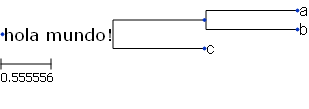

In [4]:
t = Tree( "((a,b),c);" )

# Basic tree style
ts = TreeStyle()
ts.show_leaf_name = True

# Add two text faces to different columns
t.add_face(TextFace("hola "), column=0, position = "branch-right")
t.add_face(TextFace("mundo!"), column=1, position = "branch-right")
t.render('%%inline')

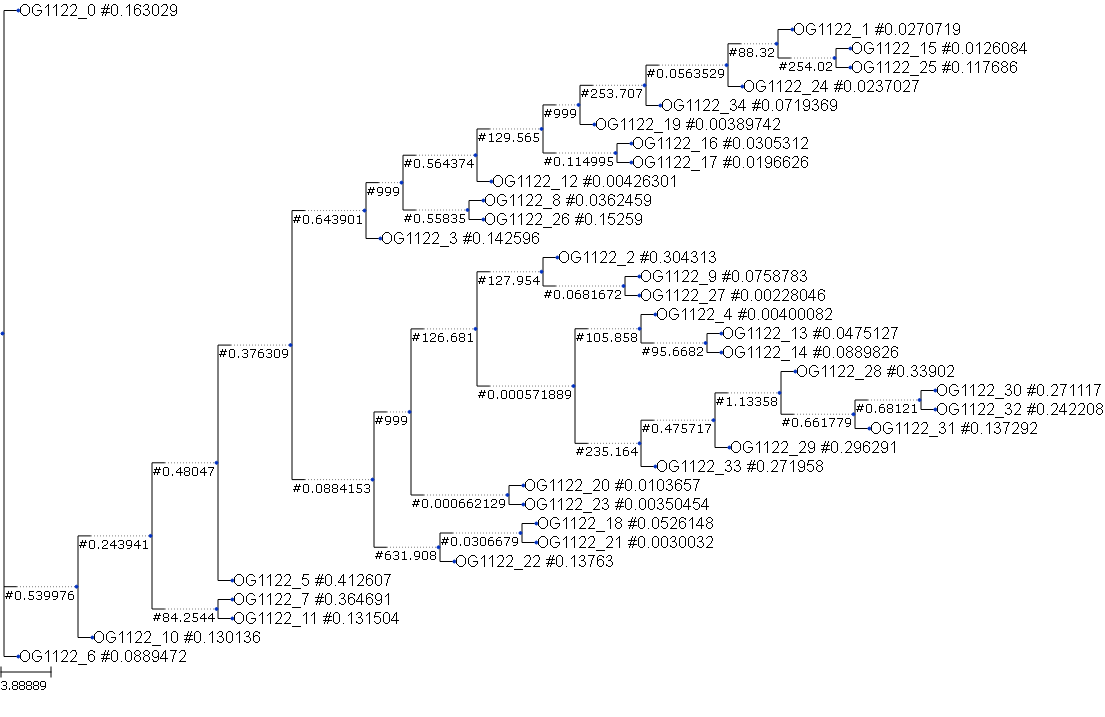

In [4]:
tree = '(OG1122_0 #0.163029 , ((((((((((((OG1122_1 #0.0270719 , (OG1122_15 #0.0126084 , OG1122_25 #0.117686 ) #254.02 ) #88.32 , OG1122_24 #0.0237027 ) #0.0563529 , OG1122_34 #0.0719369 ) #253.707 , OG1122_19 #0.00389742 ) #999 , (OG1122_16 #0.0305312 , OG1122_17 #0.0196626 ) #0.114995 ) #129.565 , OG1122_12 #0.00426301 ) #0.564374 , (OG1122_8 #0.0362459 , OG1122_26 #0.15259 ) #0.55835 ) #999 , OG1122_3 #0.142596 ) #0.643901 , ((((OG1122_2 #0.304313 , (OG1122_9 #0.0758783 , OG1122_27 #0.00228046 ) #0.0681672 ) #127.954 , ((OG1122_4 #0.00400082 , (OG1122_13 #0.0475127 , OG1122_14 #0.0889826 ) #95.6682 ) #105.858 , (((OG1122_28 #0.33902 , ((OG1122_30 #0.271117 , OG1122_32 #0.242208 ) #0.68121 , OG1122_31 #0.137292 ) #0.661779 ) #1.13358 , OG1122_29 #0.296291 ) #0.475717 , OG1122_33 #0.271958 ) #235.164 ) #0.000571889 ) #126.681 , (OG1122_20 #0.0103657 , OG1122_23 #0.00350454 ) #0.000662129 ) #999 , ((OG1122_18 #0.0526148 , OG1122_21 #0.0030032 ) #0.0306679 , OG1122_22 #0.13763 ) #631.908 ) #0.0884153 ) #0.376309 , OG1122_5 #0.412607 ) #0.48047 , (OG1122_7 #0.364691 , OG1122_11 #0.131504 ) #84.2544 ) #0.243941 , OG1122_10 #0.130136 ) #0.539976 , OG1122_6 #0.0889472 );' 
#'(OG4552_0 #0.033234 , (((((((OG4552_1 #1.19967 , OG4552_11 #0.00897308 ) #999 , OG4552_8 #0.0324229 ) #0.0411581 , (OG4552_9 #0.0304342 , OG4552_14 #2.49748 ) #0.0499443 ) #999 , OG4552_16 #0.216552 ) #1.89263 , (OG4552_10 #1.28001 , OG4552_12 #0.149252 ) #0.0694185 ) #999 , (((OG4552_2 #0.00914513 , OG4552_3 #0.212349 ) #999 , OG4552_13 #0.29135 ) #0.326615 , (OG4552_6 #0.203667 , OG4552_15 #0.36552 ) #1.42919 ) #999 ) #999 , (OG4552_4 #0.354171 , OG4552_7 #0.117535 ) #0.472012 ) #0.383123 , OG4552_5 #0.240703 );'
#'(OG4555_0 #0.371144 , (((((((OG4555_1 #0.0401007 , OG4555_14 #193.338 ) #0.0206283 , OG4555_9 #0.278729 ) #0.308471 , OG4555_15 #0.133923 ) #0.39652 , (((OG4555_2 #0.0396629 , OG4555_13 #0.00242407 ) #0.0216605 , (((OG4555_3 #0.0430765 , OG4555_11 #0.0430739 ) #0.170912 , OG4555_8 #0.416276 ) #388.26 , OG4555_4 #0.782766 ) #499.349 ) #1.62161 , (OG4555_16 #0.0438976 , OG4555_17 #0.538332 ) #329.962 ) #0.0414763 ) #339.207 , OG4555_7 #0.0748496 ) #0.148236 , (OG4555_10 #0.111478 , OG4555_12 #0.162628 ) #1.00136 ) #0.548781 , OG4555_6 #0.441593 ) #0.198348 , OG4555_5 #0.0503427 );'
t = Tree(tree, format=1)
for node in t.traverse():
    if not(node.is_leaf()):
        node.add_face(TextFace(node.name, fsize=8), column=0, position='branch-bottom')
t.ladderize
t.render('%%inline')

In [5]:
t.write(format=9)

'(OG1122_0 #0.163029,((((((((((((OG1122_1 #0.0270719,(OG1122_15 #0.0126084,OG1122_25 #0.117686)),OG1122_24 #0.0237027),OG1122_34 #0.0719369),OG1122_19 #0.00389742),(OG1122_16 #0.0305312,OG1122_17 #0.0196626)),OG1122_12 #0.00426301),(OG1122_8 #0.0362459,OG1122_26 #0.15259)),OG1122_3 #0.142596),((((OG1122_2 #0.304313,(OG1122_9 #0.0758783,OG1122_27 #0.00228046)),((OG1122_4 #0.00400082,(OG1122_13 #0.0475127,OG1122_14 #0.0889826)),(((OG1122_28 #0.33902,((OG1122_30 #0.271117,OG1122_32 #0.242208),OG1122_31 #0.137292)),OG1122_29 #0.296291),OG1122_33 #0.271958))),(OG1122_20 #0.0103657,OG1122_23 #0.00350454)),((OG1122_18 #0.0526148,OG1122_21 #0.0030032),OG1122_22 #0.13763))),OG1122_5 #0.412607),(OG1122_7 #0.364691,OG1122_11 #0.131504)),OG1122_10 #0.130136),OG1122_6 #0.0889472);'

In [ ]:
tree_dir = base_dir + os.sep + os.path.normpath('msas/structural/tm_align/trees')
out_image_dir = base_dir + os.sep + os.path.normpath('selection_calculations/tree_images')

tree_spec = 'OG4555_REF_Scer_AF-P32799-F1-model_v2.tm.fasta.clipkit.treefile'

In [6]:
tree = '(OG1122_0:0.08390,((((((((((((OG1122_1:0.22175,(OG1122_15:0.38094,OG1122_25:0.29127)95.3/97:0.07751)89.9/92:0.06258,OG1122_24:0.19383)6.7/59:0.02964,OG1122_34:0.31840)98.7/99:0.11658,OG1122_19:0.44397)88.9/93:0.05919,(OG1122_16:0.13907,OG1122_17:0.15364)100/100:0.28783)94.8/95:0.15396,OG1122_12:0.44500)100/100:0.54075,(OG1122_8:0.26859,OG1122_26:0.36227)100/100:0.49154)99.8/100:0.34900,OG1122_3:1.01773)96.6/97:0.23697,((((OG1122_2:0.62253,(OG1122_9:1.16411,OG1122_27:0.53277)91.5/81:0.14776)76.5/33:0.08702,((OG1122_4:1.11254,(OG1122_13:0.61855,OG1122_14:0.29524)99.1/100:0.18734)28.9/59:0.09258,(((OG1122_28:0.78338,((OG1122_30:0.24625,OG1122_32:0.41652)90.7/98:0.07659,OG1122_31:0.46336)96.8/98:0.11894)90.9/74:0.08752,OG1122_29:0.29594)85.9/73:0.06952,OG1122_33:0.57181)98/98:0.12384)95/83:0.10720)33.3/30:0.08133,(OG1122_20:0.45962,OG1122_23:0.96559)95.7/89:0.16852)100/100:0.89360,((OG1122_18:0.49362,OG1122_21:0.76395)81/94:0.09814,OG1122_22:0.55986)86.7/94:0.08239)63.3/60:0.08833)98.8/100:0.20573,OG1122_5:0.95026)99.1/100:0.16919,(OG1122_7:0.72969,OG1122_11:0.46483)73.1/65:0.08079)97.6/71:0.11136,OG1122_10:0.28690)100/100:0.25355,OG1122_6:0.09211):0.00000;' 
#'(OG4552_0:0.01146,(((((((OG4552_1:1.18774,OG4552_11:0.10278)54.3/37:0.03944,OG4552_8:0.37053)90.4/52:0.11541,(OG4552_9:0.48833,OG4552_14:0.31995)0/24:0.02204)74.4/41:0.08321,OG4552_16:0.14439)92.8/54:0.17278,(OG4552_10:0.44168,OG4552_12:0.32420)55.3/45:0.17703)50.5/28:0.10870,(((OG4552_2:1.16055,OG4552_3:0.48197)84.2/58:0.42301,OG4552_13:0.18740)91.7/44:0.24718,(OG4552_6:0.31351,OG4552_15:0.16489)42.5/67:0.09350)67.5/33:0.13000)92.9/39:0.18686,(OG4552_4:0.54684,OG4552_7:0.10904)71.2/58:0.07545)97.3/92:0.22923,OG4552_5:0.05663):0.00000;'
#5441: '(OG5441_0:0.61252,((((((OG5441_1:1.56251,OG5441_2:1.99194)24.5/53:0.24381,OG5441_10:1.64470)99.2/98:0.49906,((OG5441_3:0.66598,(OG5441_15:1.32214,OG5441_16:0.27522)98.9/100:0.53414)58/57:0.13056,OG5441_4:0.61813)85.1/75:0.12582)99.6/99:0.32387,(OG5441_9:0.57583,OG5441_12:0.57562)95.6/97:0.15332)97.2/88:0.15321,(OG5441_5:0.68807,OG5441_11:0.80087)65.4/40:0.08622)86.5/41:0.05874,(OG5441_6:0.43659,(OG5441_13:0.35573,OG5441_14:0.21207)100/100:0.37612)98.9/99:0.20436)45.7/44:0.06259,(OG5441_7:0.42592,OG5441_8:0.42647)100/100:0.40933):0.00000;'
#tree = '(1, (((((((2, 15), 10), 16), (((3, 14), (((4, 12), 9), 5)), (17, 18))), 8), (11, 13)), 7), 6);'

t = Tree(tree, format=1)
t.write(format=9)
#t_no_branch = EvolTree(t.write(format=9))
t.mark_tree(['2','15','10','16'], ['#1','#1','#1','#1'])

'(OG1122_0,((((((((((((OG1122_1,(OG1122_15,OG1122_25)),OG1122_24),OG1122_34),OG1122_19),(OG1122_16,OG1122_17)),OG1122_12),(OG1122_8,OG1122_26)),OG1122_3),((((OG1122_2,(OG1122_9,OG1122_27)),((OG1122_4,(OG1122_13,OG1122_14)),(((OG1122_28,((OG1122_30,OG1122_32),OG1122_31)),OG1122_29),OG1122_33))),(OG1122_20,OG1122_23)),((OG1122_18,OG1122_21),OG1122_22))),OG1122_5),(OG1122_7,OG1122_11)),OG1122_10),OG1122_6);'

In [44]:
print(t_no_branch)


   /-OG4552_0
  |
  |                     /-OG4552_1
  |                  /-|
  |               /-|   \-OG4552_11
  |              |  |
  |            /-|   \-OG4552_8
  |           |  |
  |           |  |   /-OG4552_9
  |         /-|   \-|
  |        |  |      \-OG4552_14
  |        |  |
  |      /-|   \-OG4552_16
  |     |  |
  |     |  |   /-OG4552_10
  |     |   \-|
--|     |      \-OG4552_12
  |   /-|
  |  |  |         /-OG4552_2
  |  |  |      /-|
  |  |  |   /-|   \-OG4552_3
  |  |  |  |  |
  |  |   \-|   \-OG4552_13
  |--|     |
  |  |     |   /-OG4552_6
  |  |      \-|
  |  |         \-OG4552_15
  |  |
  |  |   /-OG4552_4
  |   \-|
  |      \-OG4552_7
  |
   \-OG4552_5


In [56]:
### To Load Tree in Jalview, the name needs to match the alignment.  The alignment has all these other items in it

og_ref = 'OG1122_REF_Scer_AF-P13711-F1-model_v2'
orig_aln_fname = base_dir + os.sep + os.path.normpath('msas/structural/tm_align/fasta_renamed/' + og_ref + '.tm.fasta')
jalview_aln_fname = base_dir + os.sep + os.path.normpath('msas/structural/tm_align/fasta_renamed_jalview/' + og_ref + '.tm.fasta')

orig_aln = SeqIO.parse(orig_aln_fname, 'fasta')

with open(jalview_aln_fname,'w') as f_out:
    for record in orig_aln: 
        f_out.write('>' + record.id + '\n')
        f_out.write(str(record.seq) + '\n')
    